# **Дипломный проект. Специализация "Data Scientist"**
## Тема: Машинное обучение для предсказания дефолта по кредиту
### Малинина Елена группа DSU - 1

Датасет можно скачать [здесь](https://www.kaggle.com/competitions/home-credit-default-risk/data?select=application_test.csv)

* SK_ID_CURR - ID займа
* TARGET - целевая переменная (1 - кредит не выплачен, 0 - кредит выплачен)
*	NAME_CONTRACT_TYPE - тип займа (револьверный кредит / кредит наличными)
* CODE_GENDER	- пол заемщика
* NAME_TYPE_SUITE - кто сопровождал клиента
* FLAG_OWN_CAR	- наличие машины
* OWN_CAR_AGE - возраст машины заемщика
* CNT_FAM_MEMBERS - количество близких родственников у клиента
* FLAG_OWN_REALTY	- наличие недвижимости
* CNT_CHILDREN	- количство детей
* AMT_INCOME_TOTAL	- доход клиента
* AMT_CREDIT	- сумма кредита
* AMT_ANNUITY	- годовой кредит
* AMT_GOODS_PRICE - цена товара приобретенного в кредит
* NAME_INCOME_TYPE - тип дохода(бизнес, рабочий, декрет...) 
* NAME_EDUCATION_TYPE - образование
* NAME_FAMILY_STATUS - семейное положение
* DAYS_BIRTH - возраст
* OCCUPATION_TYPE - профессия клиента
* ORGANIZATION_TYPE - где работает клиент
* NAME_HOUSING_TYPE - тип жилья
* CNT_FAM_MEMBERS - количество родственников
* AMT_REQ_CREDIT_BUREAU_HOUR - количество запросов на кредит
* FLAG_MOBIL - указал мобильный телефон (1 - да, 0 - нет)
* FLAG_WORK_PHONE - указал  рабочий телефон (1 - да, 0 - нет)
* DAYS_EMPLOYED - количество отработанных дней на текущей работе
* FLAG_EMAIL - указал email (1 - да, 0 - нет)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve
!pip install catboost
!pip install -U imbalanced-learn
import catboost as catb
from catboost import Pool
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# **Загрузка данных**

In [4]:
df_train = pd.read_csv('data/application_train.csv') # основной датасет
previous_application = pd.read_csv('data/previous_application.csv') # все предыдущие заявки на кредит
POS_CASH_balance = pd.read_csv('data/POS_CASH_balance.csv') # баланс на кредитном счете
credit_card_balance = pd.read_csv('data/credit_card_balance.csv') # баланс на предыдущем кредитном счете
bureau = pd.read_csv('data/bureau.csv')
print('Размер тренировочного датасета:', df_train.shape)

Размер тренировочного датасета: (307511, 122)


In [5]:
pd.set_option("display.max.columns", None)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [6]:
df_train.describe().transpose()

count           mean            std       min  \
SK_ID_CURR                  307511.0  278180.518577  102790.175348  100002.0   
TARGET                      307511.0       0.080729       0.272419       0.0   
CNT_CHILDREN                307511.0       0.417052       0.722121       0.0   
AMT_INCOME_TOTAL            307511.0  168797.919297  237123.146279   25650.0   
AMT_CREDIT                  307511.0  599025.999706  402490.776996   45000.0   
...                              ...            ...            ...       ...   
AMT_REQ_CREDIT_BUREAU_DAY   265992.0       0.007000       0.110757       0.0   
AMT_REQ_CREDIT_BUREAU_WEEK  265992.0       0.034362       0.204685       0.0   
AMT_REQ_CREDIT_BUREAU_MON   265992.0       0.267395       0.916002       0.0   
AMT_REQ_CREDIT_BUREAU_QRT   265992.0       0.265474       0.794056       0.0   
AMT_REQ_CREDIT_BUREAU_YEAR  265992.0       1.899974       1.869295       0.0   

                                 25%       50%       75%          max  
SK_ID_CURR                  189145.5  278202.0  367142.5     456255.0  
TARGET                           0.0       0.0       0.0          1.0  
CNT_CHILDREN                     0.0       0.0       1.0         19.0  
AMT_INCOME_TOTAL            112500.0  147150.0  202500.0  117000000.0  
AMT_CREDIT                  270000.0  513531.0  808650.0    4050000.0  
...                              ...       ...       ...          ...  
AMT_REQ_CREDIT_BUREAU_DAY        0.0       0.0       0.0          9.0  
AMT_REQ_CREDIT_BUREAU_WEEK       0.0       0.0       0.0          8.0  
AMT_REQ_CREDIT_BUREAU_MON        0.0       0.0       0.0         27.0  
AMT_REQ_CREDIT_BUREAU_QRT        0.0       0.0       0.0        261.0  
AMT_REQ_CREDIT_BUREAU_YEAR       0.0       1.0       3.0         25.0  

[106 rows x 8 columns]

In [7]:
df_train.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

In [8]:
df_train = df_train.join(previous_application, how='left', on='SK_ID_CURR', rsuffix='_previous')
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [9]:
df_train = df_train.join(POS_CASH_balance, how='left', on='SK_ID_CURR', rsuffix='_POS_CASH')
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [10]:
df_train = df_train.join(credit_card_balance, how='left', on='SK_ID_CURR', rsuffix='_credit')
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [11]:
df_train = df_train.join(bureau, how='left', on='SK_ID_CURR', rsuffix='_bureau')
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [12]:
df_train.shape

(307511, 207)



---


# **EDA Part 1.0**

In [13]:
# поиск дубликатов
df_train.duplicated().value_counts()

False    307511
dtype: int64

***Целевая переменная и распределение***

Text(0, 0.5, 'Кол-во заявителей')

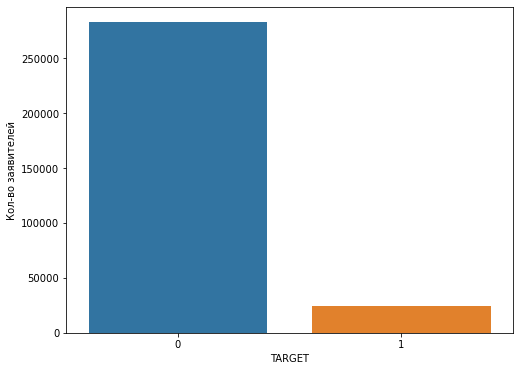

In [14]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.countplot(x = 'TARGET', data = df_train)
plt.ylabel('Кол-во заявителей')

Данные не сбалансированы

In [15]:
target_count = df_train['TARGET'].value_counts()
print('Класс 0:', target_count[0])
print('Класс 1:', target_count[1])

Класс 0: 282686
Класс 1: 24825




---



***Тип контракта***

Text(0, 0.5, 'Кол-во заявителей')

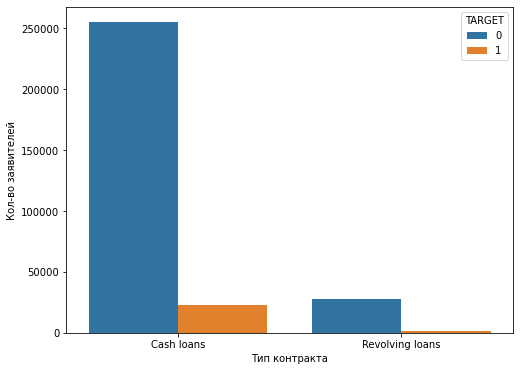

In [16]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.countplot(x = 'NAME_CONTRACT_TYPE', hue = 'TARGET', data = df_train)
plt.xlabel('Тип контракта')
plt.ylabel('Кол-во заявителей')

Револьверные кредиты берут реже


---



***Кто чаще берет кредиты***

Text(0, 0.5, 'Кол-во заявителей')

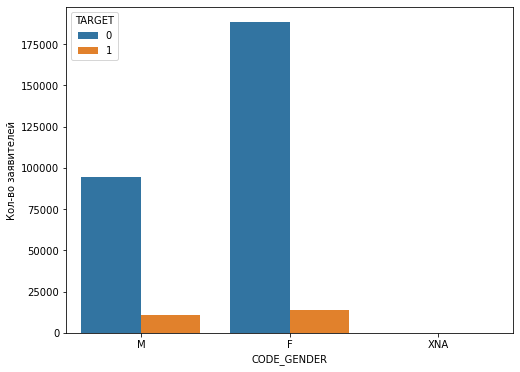

In [17]:
fig, ax = plt.subplots(figsize = (8, 6))
sns.countplot(x = 'CODE_GENDER', hue = 'TARGET', data = df_train)
plt.ylabel('Кол-во заявителей')

In [18]:
df_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [19]:
df_train[df_train['CODE_GENDER'] == 'XNA']

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
35657       141289       0    Revolving loans         XNA            Y   
38566       144669       0    Revolving loans         XNA            N   
83382       196708       0    Revolving loans         XNA            N   
189640      319880       0    Revolving loans         XNA            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
35657                Y             0          207000.0    382500.0   
38566                Y             2          157500.0    270000.0   
83382                Y             1          135000.0    405000.0   
189640               Y             0          247500.0    540000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
35657       19125.0         337500.0   Unaccompanied               Working   
38566       13500.0         225000.0          Family               Working   
83382       20250.0         225000.0   Unaccompanied               Working   
189640      27000.0         900000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
35657   Secondary / secondary special            Married  Municipal apartment   
38566   Secondary / secondary special            Married    House / apartment   
83382                Higher education            Married    House / apartment   
189640              Incomplete higher     Civil marriage    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
35657                     0.020713      -20232         -10044   
38566                     0.026392      -13717          -2797   
83382                     0.035792      -10647          -1228   
189640                    0.035792       -9649          -2293   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
35657            -10024.0            -3537         13.0           1   
38566             -2241.0            -4659          NaN           1   
83382              -183.0            -1671          NaN           1   
189640            -4099.0            -2326          8.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
35657                1                1                 1           1   
38566                1                1                 1           1   
83382                1                1                 1           1   
189640               1                1                 1           1   

        FLAG_EMAIL     OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
35657            0                 NaN              2.0                     3   
38566            0  Low-skill Laborers              4.0                     2   
83382            0          Core staff              3.0                     2   
189640           0                 NaN              2.0                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
35657                             3                    TUESDAY   
38566                             2                     FRIDAY   
83382                             2                   THURSDAY   
189640                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
35657                        10                           0   
38566                        16                           0   
83382                        15                           0   
189640                       15                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
35657                            0                            0   
38566                            0                            0   
83382                            0                            0   
189640                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CI

Эти данные можно убрать, их всего 4 шт

In [20]:
df_train = df_train.drop(df_train[df_train['CODE_GENDER'] == 'XNA'].index)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        



---



***Возраст клиента***

Text(0.5, 0, 'Возраст клиента (кол-во лет)')

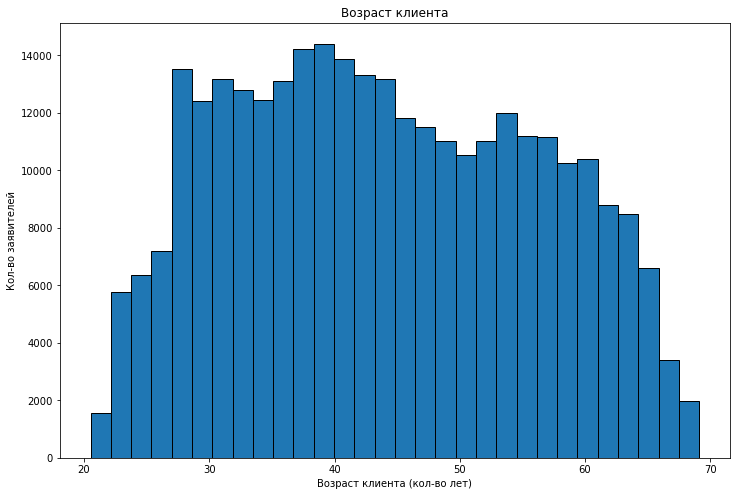

In [21]:
plt.figure(figsize = (12, 8))
plt.hist(df_train['DAYS_BIRTH'] / -365, bins = 30, edgecolor = 'k')
plt.title('Возраст клиента')
plt.ylabel('Кол-во заявителей')
plt.xlabel('Возраст клиента (кол-во лет)')

Всплеск приходится от 25 до 45 лет

Text(0.5, 1.0, 'Возможность погасить кредит')

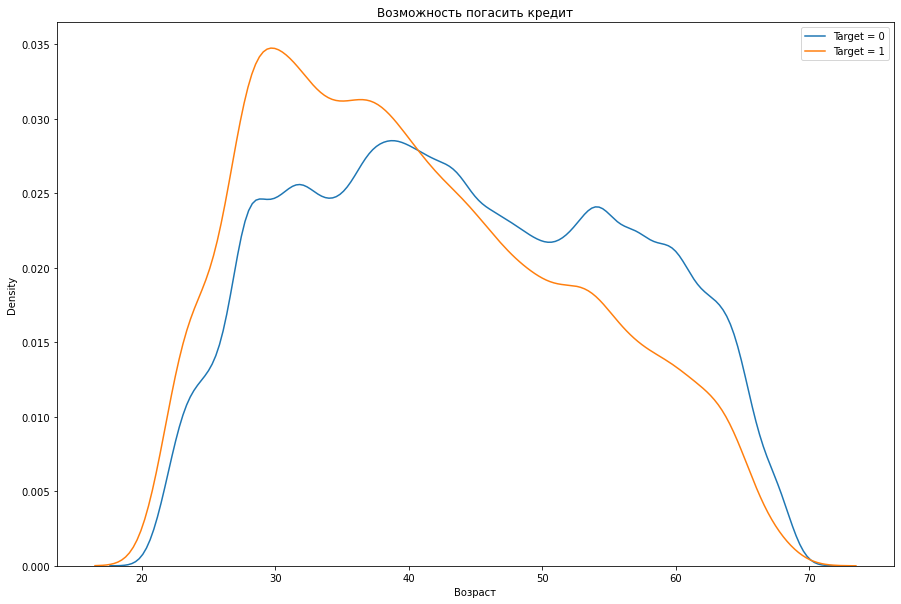

In [22]:
plt.figure(figsize = (15,10))
sns.kdeplot(df_train.loc[df_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'Target = 0')
sns.kdeplot(df_train.loc[df_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'Target = 1')
plt.xlabel('Возраст')
plt.legend()
plt.title('Возможность погасить кредит')

Вероятность не погасить кредит возрастает примерно с 25-26 лет

<AxesSubplot:xlabel='DAYS_BIRTH'>

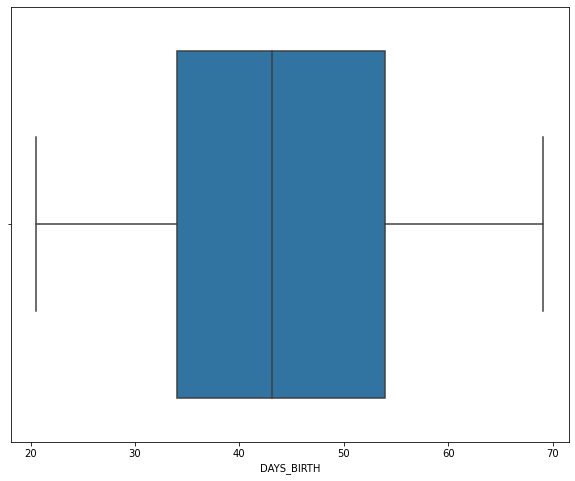

In [23]:
plt.figure(figsize = (10,8))
sns.boxplot(x = df_train['DAYS_BIRTH'] / -365)

In [24]:
df_train['DAYS_BIRTH'] = abs(df_train['DAYS_BIRTH'])
df_train['DAYS_BIRTH'].corr(df_train['TARGET'])

-0.07824216003619362

Видимо, с возрастом люди стараются погасть кредит как можно скорее


---



***Возраст машины клиента***

Text(0.5, 0, 'Возраст машины клиента (лет)')

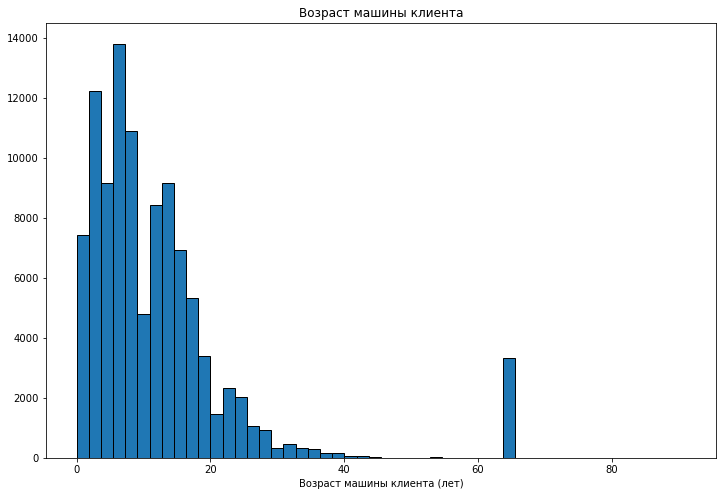

In [25]:
plt.figure(figsize = (12, 8))
plt.hist(df_train['OWN_CAR_AGE'], bins = 50, edgecolor = 'k')
plt.title('Возраст машины клиента')
plt.xlabel('Возраст машины клиента (лет)')

Text(0.5, 0, 'Возраст машины клиента (лет)')

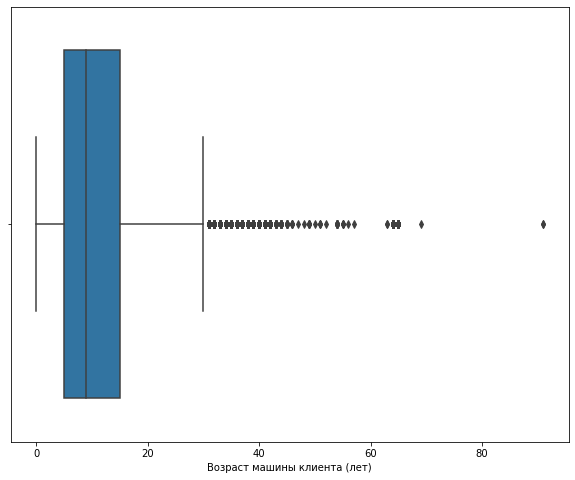

In [26]:
plt.figure(figsize = (10, 8))
sns.boxplot(x = df_train['OWN_CAR_AGE'])
plt.xlabel('Возраст машины клиента (лет)')

In [27]:
df_train[df_train['OWN_CAR_AGE'] > 65]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
161390      287098       0         Cash loans           M            Y   
271741      415025       1         Cash loans           M            Y   
294131      440757       0    Revolving loans           M            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
161390               Y             0          315000.0   1125000.0   
271741               Y             1          180000.0    675000.0   
294131               N             1          112500.0    180000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
161390      47794.5        1125000.0   Unaccompanied  Commercial associate   
271741      34465.5         675000.0   Unaccompanied               Working   
294131       9000.0         180000.0          Family               Working   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
161390               Higher education            Married  House / apartment   
271741  Secondary / secondary special            Married       With parents   
294131  Secondary / secondary special            Married  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
161390                    0.025164       18613          -2827   
271741                    0.018209        9894          -1320   
294131                    0.018850       11195           -897   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
161390             -436.0            -2165         69.0           1   
271741            -4675.0            -2559         91.0           1   
294131            -3582.0            -3691         91.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
161390               1                0                 1           0   
271741               1                1                 1           1   
294131               1                0                 1           0   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
161390           1        Managers              2.0                     2   
271741           0         Drivers              3.0                     3   
294131           0         Drivers              3.0                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
161390                            2                   THURSDAY   
271741                            3                    TUESDAY   
294131                            2                  WEDNESDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
161390                       12                           0   
271741                       13                           0   
294131                       14                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
161390                           0                            0   
271741                           0                            0   
294131                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
161390                       0                       0   
271741                       0                       0   
294131                       0                       0   

        LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  \
161390                        0  Business Entity Type 3      0.807885   
271741                        0  Business Entity Type 3           NaN   
294131                        0        Industry: type 4           NaN   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
161390      0.520360      0.712155             NaN               NaN   
271741      0.523138      0.133429             NaN               NaN   
294131      0.686340      0.794629          0.0124             0.025   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_A

Уберем такие большие выбросы

In [28]:
df_train = df_train.drop(df_train[df_train['OWN_CAR_AGE'] > 65].index)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461           -637            -3648.0   
1                    0.003541       16765          -1188            -1186.0   
2                    0.010032       19046           -225            -4260.0   
3                    0.008019       19005          -3039            -9833.0   
4                    0.028663       19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        



---



***Где работает клиент***

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Laborers'),
  Text(1, 0, 'Core staff'),
  Text(2, 0, 'Accountants'),
  Text(3, 0, 'Managers'),
  Text(4, 0, 'Drivers'),
  Text(5, 0, 'Sales staff'),
  Text(6, 0, 'Cleaning staff'),
  Text(7, 0, 'Cooking staff'),
  Text(8, 0, 'Private service staff'),
  Text(9, 0, 'Medicine staff'),
  Text(10, 0, 'Security staff'),
  Text(11, 0, 'High skill tech staff'),
  Text(12, 0, 'Waiters/barmen staff'),
  Text(13, 0, 'Low-skill Laborers'),
  Text(14, 0, 'Realty agents'),
  Text(15, 0, 'Secretaries'),
  Text(16, 0, 'IT staff'),
  Text(17, 0, 'HR staff')])

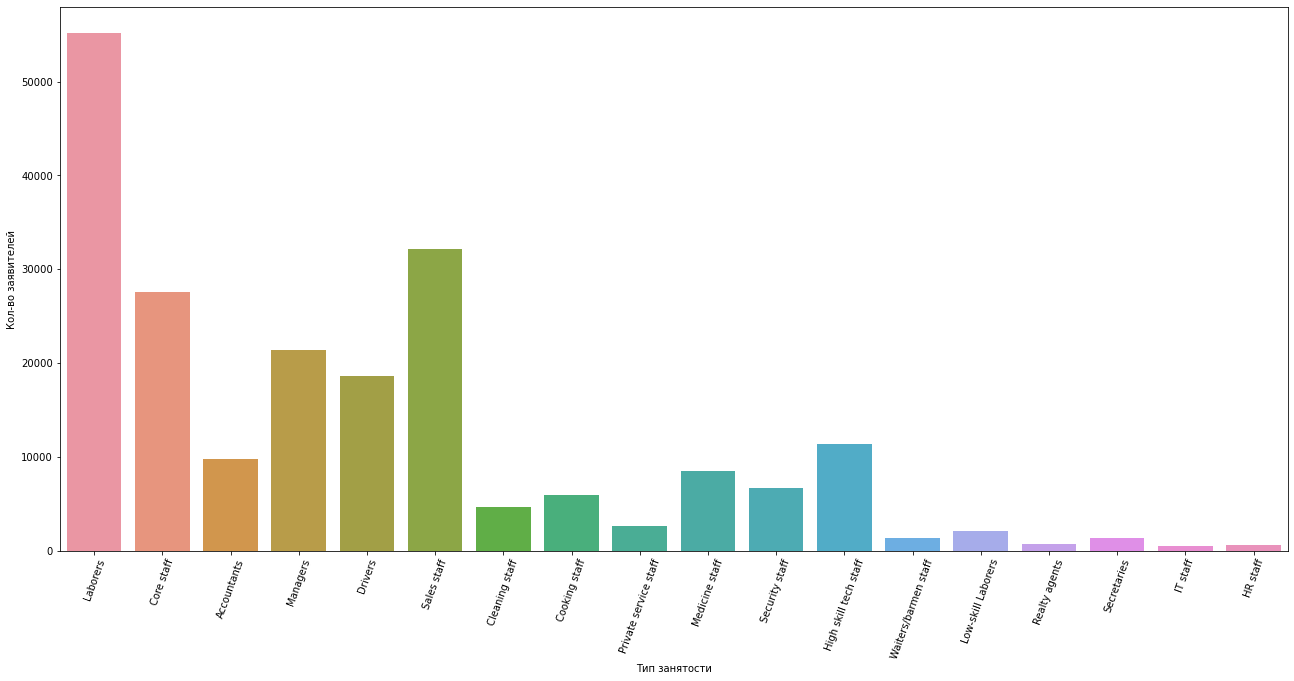

In [29]:
fig, ax = plt.subplots(figsize=(22,10))
sns.countplot(x = 'OCCUPATION_TYPE', data = df_train)
plt.xlabel("Тип занятости")
plt.ylabel('Кол-во заявителей')
plt.xticks(rotation=70)


Больше всего рабочих, меньше IT и HR отделы

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Laborers'),
  Text(1, 0, 'Core staff'),
  Text(2, 0, 'Accountants'),
  Text(3, 0, 'Managers'),
  Text(4, 0, 'Drivers'),
  Text(5, 0, 'Sales staff'),
  Text(6, 0, 'Cleaning staff'),
  Text(7, 0, 'Cooking staff'),
  Text(8, 0, 'Private service staff'),
  Text(9, 0, 'Medicine staff'),
  Text(10, 0, 'Security staff'),
  Text(11, 0, 'High skill tech staff'),
  Text(12, 0, 'Waiters/barmen staff'),
  Text(13, 0, 'Low-skill Laborers'),
  Text(14, 0, 'Realty agents'),
  Text(15, 0, 'Secretaries'),
  Text(16, 0, 'IT staff'),
  Text(17, 0, 'HR staff')])

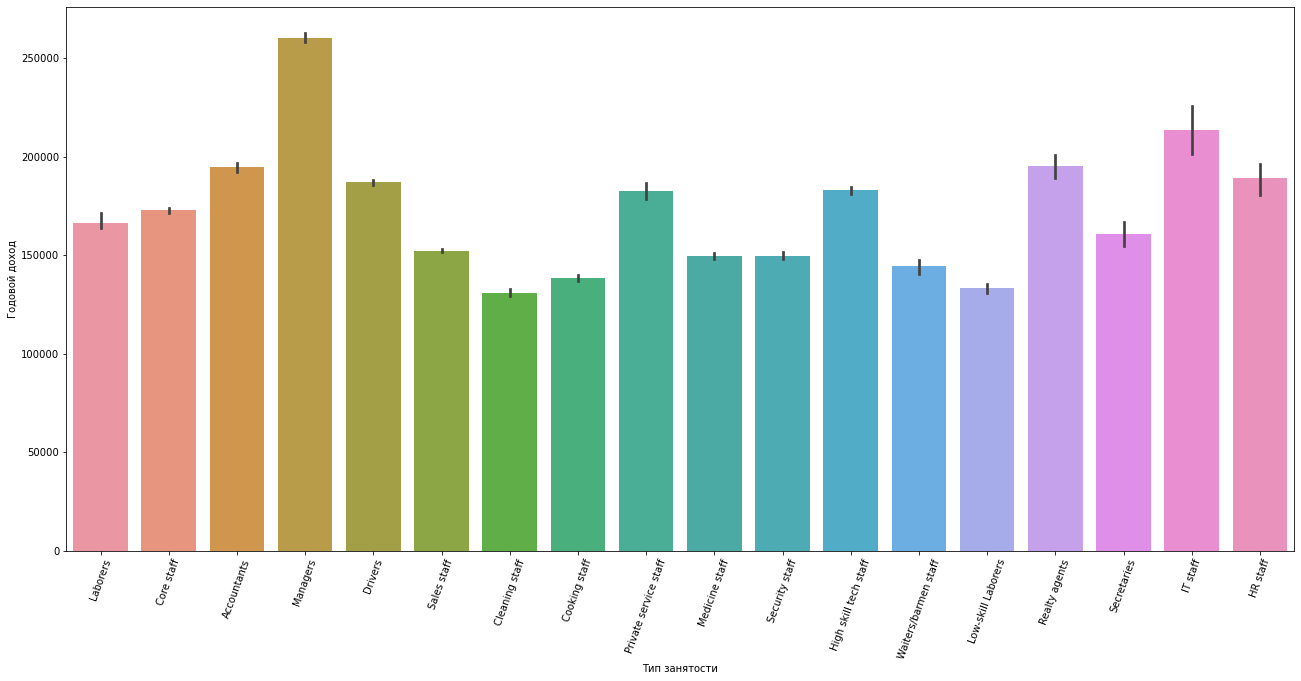

In [30]:
fig, ax = plt.subplots(figsize = (22, 10))
sns.barplot(x = 'OCCUPATION_TYPE', y = 'AMT_INCOME_TOTAL', data = df_train)
plt.xlabel("Тип занятости")
plt.ylabel('Годовой доход')
plt.xticks(rotation = 70)


Наиболее финансово стабильны менеджеры, IT и HR


---



(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 [Text(0, 0, 'Laborers'),
  Text(1, 0, 'Core staff'),
  Text(2, 0, 'Accountants'),
  Text(3, 0, 'Managers'),
  Text(4, 0, 'Drivers'),
  Text(5, 0, 'Sales staff'),
  Text(6, 0, 'Cleaning staff'),
  Text(7, 0, 'Cooking staff'),
  Text(8, 0, 'Private service staff'),
  Text(9, 0, 'Medicine staff'),
  Text(10, 0, 'Security staff'),
  Text(11, 0, 'High skill tech staff'),
  Text(12, 0, 'Waiters/barmen staff'),
  Text(13, 0, 'Low-skill Laborers'),
  Text(14, 0, 'Realty agents'),
  Text(15, 0, 'Secretaries'),
  Text(16, 0, 'IT staff'),
  Text(17, 0, 'HR staff')])

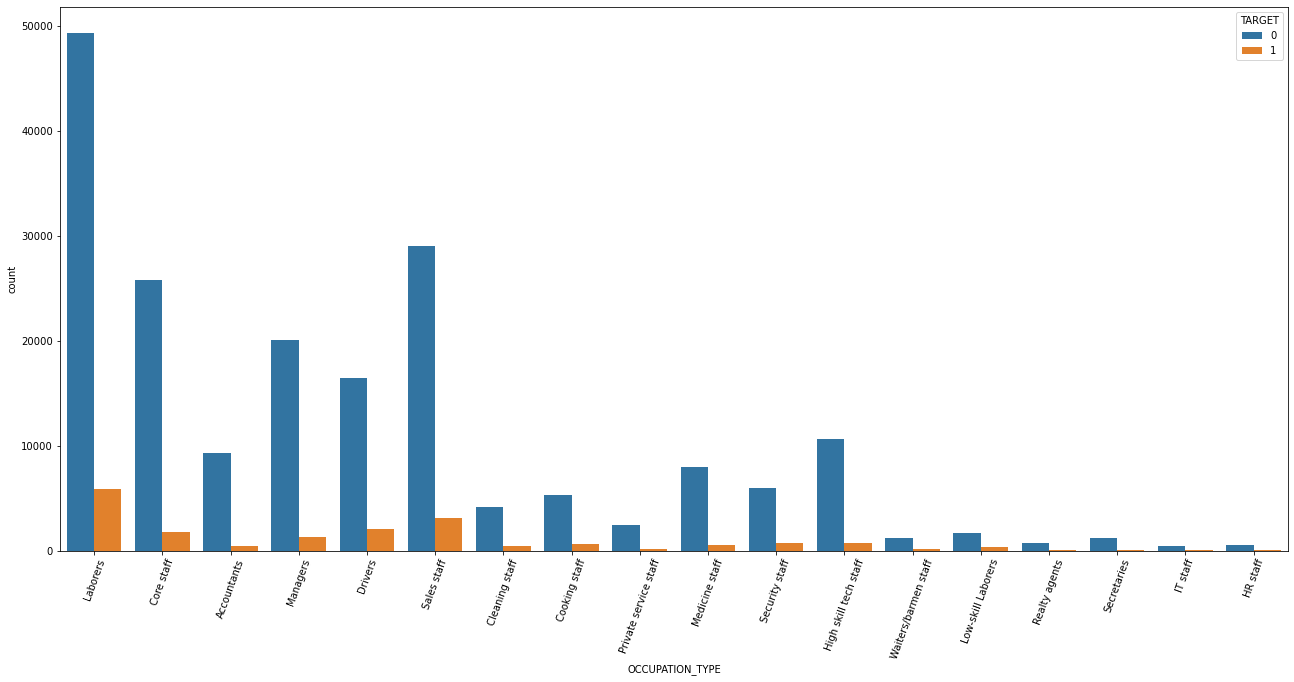

In [31]:
fig, ax = plt.subplots(figsize = (22, 10))
sns.countplot(x = 'OCCUPATION_TYPE', hue = 'TARGET', data = df_train)
plt.xticks(rotation = 70)

Чаще трудность с возратом кредита у обычных рабочих, IT кажется самым безопасным сектором для кредитования

***Семейный статус***

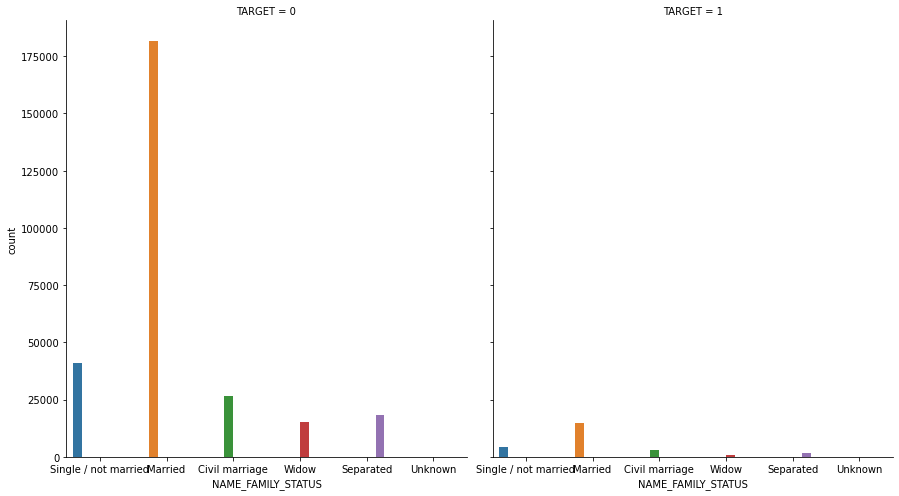

In [32]:
sns.catplot(x = 'NAME_FAMILY_STATUS', col = 'TARGET', kind = 'count', data = df_train, hue = 'NAME_FAMILY_STATUS', height = 7, aspect = 0.9)

In [33]:
df_train[df_train['NAME_FAMILY_STATUS'] == 'Unknown']

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
41982       148605       0    Revolving loans           M            N   
187348      317181       0    Revolving loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
41982                Y             0          450000.0    675000.0   
187348               Y             0          202500.0    585000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
41982       33750.0              NaN             NaN  Commercial associate   
187348      29250.0              NaN             NaN  Commercial associate   

       NAME_EDUCATION_TYPE NAME_FAMILY_STATUS    NAME_HOUSING_TYPE  \
41982      Lower secondary            Unknown  Municipal apartment   
187348    Higher education            Unknown    House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
41982                     0.015221       12396          -1161   
187348                    0.031329       12844           -232   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
41982             -3265.0            -4489          NaN           1   
187348            -1597.0            -1571          NaN           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
41982                1                1                 1           1   
187348               1                0                 1           0   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
41982            0        Managers              NaN                     2   
187348           0     Accountants              NaN                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
41982                             2                   THURSDAY   
187348                            2                     FRIDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
41982                        15                           0   
187348                       14                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
41982                            1                            1   
187348                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
41982                        0                       1   
187348                       0                       0   

        LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  \
41982                         1               Insurance      0.628564   
187348                        0  Business Entity Type 2           NaN   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
41982       0.700618           NaN             NaN               NaN   
187348      0.645168      0.670652          0.1031            0.0467   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
41982                           NaN              NaN             NaN   
187348                        0.997           0.9592          0.0081   

        ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
41982             NaN            NaN            NaN            NaN   
187348           0.08          0.069          0.375         0.4167   

        LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
41982            NaN                   NaN             NaN   
187348           NaN                0.0841           0.088   

        NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
41982                       NaN                NaN              NaN   
187348                      0.0                0.0            0.105   

        BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
41982                 NaN                           NaN               NaN   
187348             0.0485                         0.997            0.9608   

  

Эти данные лучше убрать, их мало

In [34]:
df_train = df_train.drop(df_train[df_train['NAME_FAMILY_STATUS'] == 'Unknown'].index)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461           -637            -3648.0   
1                    0.003541       16765          -1188            -1186.0   
2                    0.010032       19046           -225            -4260.0   
3                    0.008019       19005          -3039            -9833.0   
4                    0.028663       19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        



---





---


***Образование заемщиков и кто чаще берет кредиты***


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Secondary / secondary special'),
  Text(1, 0, 'Higher education'),
  Text(2, 0, 'Incomplete higher'),
  Text(3, 0, 'Lower secondary'),
  Text(4, 0, 'Academic degree')])

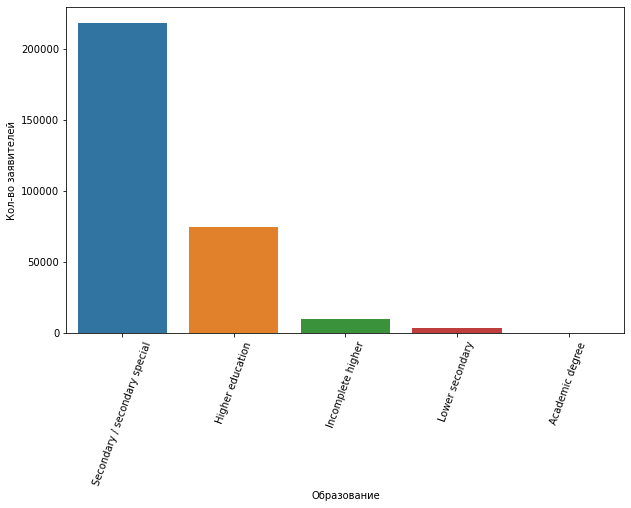

In [35]:
fig, ax = plt.subplots(figsize=(10,6))
sns.countplot(x = 'NAME_EDUCATION_TYPE', data = df_train)
plt.xlabel("Образование")
plt.ylabel('Кол-во заявителей')
plt.xticks(rotation=70)

Много заемщиков со средним / спец.среднем образовании

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Secondary / secondary special'),
  Text(1, 0, 'Higher education'),
  Text(2, 0, 'Incomplete higher'),
  Text(3, 0, 'Lower secondary'),
  Text(4, 0, 'Academic degree')])

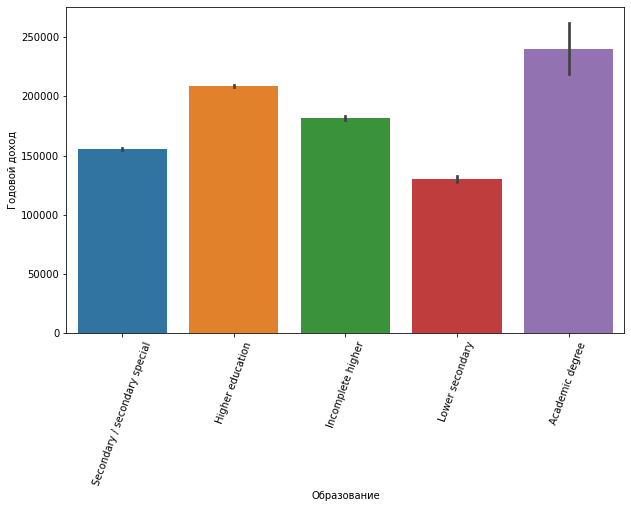

In [36]:
fig, ax = plt.subplots(figsize = (10, 6))
sns.barplot(x = 'NAME_EDUCATION_TYPE', y = 'AMT_INCOME_TOTAL', data = df_train)
plt.xlabel('Образование')
plt.ylabel('Годовой доход')
plt.xticks(rotation = 70)

Больше всего зарплата у людей с ученой степенью  и они же реже всего берут кредиты



---


***Количество детей***

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '14'),
  Text(14, 0, '19')])

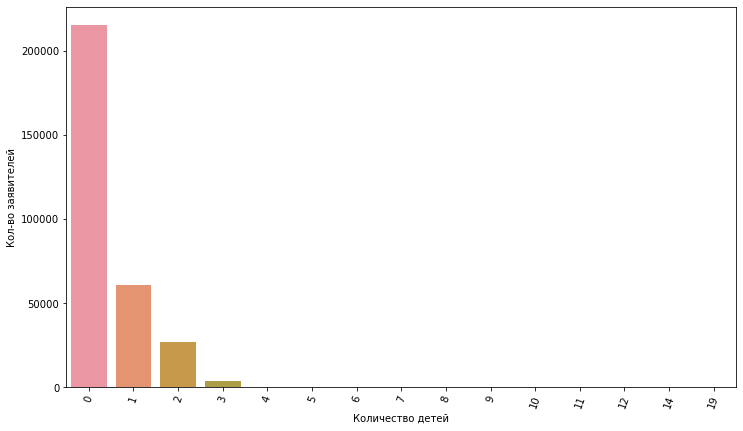

In [37]:
fig, ax = plt.subplots(figsize=(12,7))
sns.countplot(x = 'CNT_CHILDREN',data = df_train)
plt.xlabel("Количество детей")
plt.ylabel('Кол-во заявителей')
plt.xticks(rotation=70)

Большинство детей не имеют

Text(0.5, 0, 'Кол-во детей')

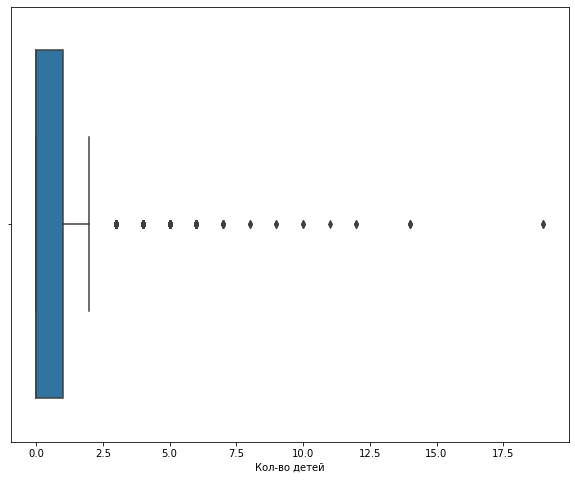

In [38]:
plt.figure(figsize = (10, 8))
sns.boxplot(x = df_train['CNT_CHILDREN'])
plt.xlabel('Кол-во детей')

In [39]:
df_train[df_train['CNT_CHILDREN'] > 10]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
34545       140032       1         Cash loans           M            Y   
80948       193853       0         Cash loans           F            N   
155369      280108       0         Cash loans           F            N   
171125      298322       0    Revolving loans           F            N   
176011      303956       0         Cash loans           M            Y   
183878      313127       0         Cash loans           F            Y   
265784      407877       0         Cash loans           F            N   
267998      410527       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
34545                N            11          315000.0   1007761.5   
80948                Y            12          337500.0    746280.0   
155369               Y            19          112500.0    269550.0   
171125               Y            12          225000.0    202500.0   
176011               Y            14          225000.0   1085058.0   
183878               N            14           45000.0    810000.0   
265784               Y            19          112500.0    135000.0   
267998               N            14           54000.0    604152.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
34545       38515.5         927000.0   Unaccompanied               Working   
80948       59094.0         675000.0          Family  Commercial associate   
155369      13891.5         225000.0          Family               Working   
171125      10125.0         202500.0          Family  Commercial associate   
176011      55530.0         891000.0        Children               Working   
183878      23814.0         810000.0   Unaccompanied             Pensioner   
265784       8788.5         135000.0   Unaccompanied               Working   
267998      25596.0         540000.0   Unaccompanied               Working   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
34545   Secondary / secondary special               Married   
80948   Secondary / secondary special               Married   
155369  Secondary / secondary special  Single / not married   
171125  Secondary / secondary special               Married   
176011  Secondary / secondary special             Separated   
183878  Secondary / secondary special               Married   
265784               Higher education  Single / not married   
267998  Secondary / secondary special               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
34545   House / apartment                    0.010643       17308   
80948   House / apartment                    0.046220       14093   
155369  House / apartment                    0.007020       11057   
171125  House / apartment                    0.046220       13894   
176011  House / apartment                    0.031329       17754   
183878  House / apartment                    0.008625       20308   
265784  House / apartment                    0.015221       10297   
267998  House / apartment                    0.011703       15463   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
34545            -198            -3940.0             -844         12.0   
80948           -2710            -2066.0            -3908          NaN   
155369          -1853            -3096.0             -745          NaN   
171125          -2542            -1867.0            -3709          NaN   
176011          -1689            -7149.0            -1298         16.0   
183878         365243           -12416.0            -3829          6.0   
265784           -896            -4733.0            -2599          NaN   
267998           -540            -6222.0            -4317          NaN   

        FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  \
34545            1               1                0                 1   
8094

In [40]:
df_train['CNT_CHILDREN'] = abs(df_train['CNT_CHILDREN'])
df_train['CNT_CHILDREN'].corr(df_train['TARGET'])

0.019179800352700154

Наверное эти данные тоже лучше убрать, может быть прекос в данных

In [41]:
df_train = df_train.drop(df_train[df_train['CNT_CHILDREN'] > 10].index)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461           -637            -3648.0   
1                    0.003541       16765          -1188            -1186.0   
2                    0.010032       19046           -225            -4260.0   
3                    0.008019       19005          -3039            -9833.0   
4                    0.028663       19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

***Тип дохода***

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'Working'),
  Text(1, 0, 'State servant'),
  Text(2, 0, 'Commercial associate'),
  Text(3, 0, 'Pensioner'),
  Text(4, 0, 'Unemployed'),
  Text(5, 0, 'Student'),
  Text(6, 0, 'Businessman'),
  Text(7, 0, 'Maternity leave')])

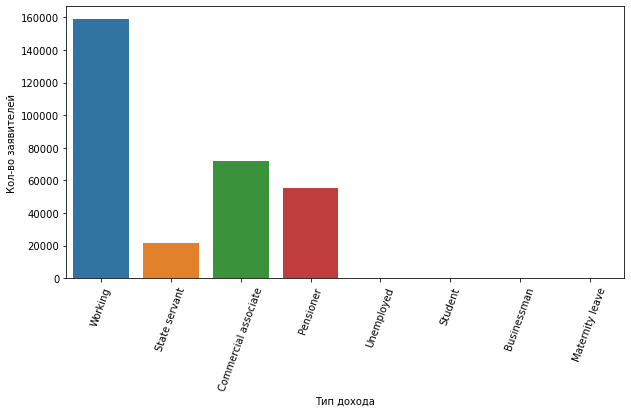

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
sns.countplot(x = 'NAME_INCOME_TYPE', data = df_train)
plt.xlabel("Тип дохода")
plt.ylabel('Кол-во заявителей')
plt.xticks(rotation = 70)

Большиство имеют работу, так же достаточно много пенсионеров

In [43]:
df_train[df_train['NAME_INCOME_TYPE'] == 'Unemployed']

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
1156        101358       0    Revolving loans           F            N   
3937        104600       0    Revolving loans           F            N   
23834       127729       1         Cash loans           F            N   
35352       140949       0         Cash loans           F            N   
37512       143454       1         Cash loans           M            Y   
41723       148306       0    Revolving loans           F            N   
77179       189489       0         Cash loans           F            N   
78336       190812       1         Cash loans           F            N   
80704       193571       1         Cash loans           F            N   
92061       206901       0    Revolving loans           M            Y   
114273      232520       0         Cash loans           M            Y   
146286      269611       0    Revolving loans           F            N   
158670      283948       0         Cash loans           F            Y   
175433      303289       0         Cash loans           F            Y   
204212      336749       0         Cash loans           F            Y   
209722      343054       1         Cash loans           F            N   
209835      343178       1         Cash loans           F            N   
213274      347145       0         Cash loans           F            N   
216436      350785       1         Cash loans           F            N   
237750      375382       1         Cash loans           M            Y   
268617      411290       0    Revolving loans           F            N   
305365      453794       0    Revolving loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
1156                 N             0          337500.0    585000.0   
3937                 Y             2          135000.0    270000.0   
23834                Y             0           99000.0    783000.0   
35352                N             0           56250.0   1530000.0   
37512                Y             0           31500.0    585000.0   
41723                Y             0          270000.0    135000.0   
77179                N             1           54000.0    634500.0   
78336                Y             0           45000.0    328500.0   
80704                Y             0           90000.0    571500.0   
92061                Y             0          270000.0    855000.0   
114273               Y             0           63000.0   1381500.0   
146286               Y             0          225000.0    720000.0   
158670               N             0           90000.0   1804500.0   
175433               Y             0           26550.0    571500.0   
204212               N             0           54000.0   1080000.0   
209722               N             0           63000.0   1215000.0   
209835               Y             0          135000.0    387000.0   
213274               Y             0           27000.0    886500.0   
216436               N             0           45000.0    634500.0   
237750               Y             1           67500.0    508500.0   
268617               Y             0          135000.0    450000.0   
305365               Y             0          112500.0    900000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
1156        29250.0         585000.0   Unaccompanied       Unemployed   
3937        13500.0         270000.0   Unaccompanied       Unemployed   
23834       22306.5         783000.0   Unaccompanied       Unemployed   
35352       54954.0        1530000.0   Unaccompanied       Unemployed   
37512       26892.0         585000.0   Unaccompanied       Unemployed   
41723        6750.0         135000.0   Unaccompanied       Unemployed   
77179       23643.0         634500.0   Unaccompanied       Unemployed   
78336       10629.0         328500.0   Unaccompanied       Unemployed   
80704       20524.5         571500.0 



---


***Годовой доход***

Text(0, 0.5, 'Кол-во заявителей')

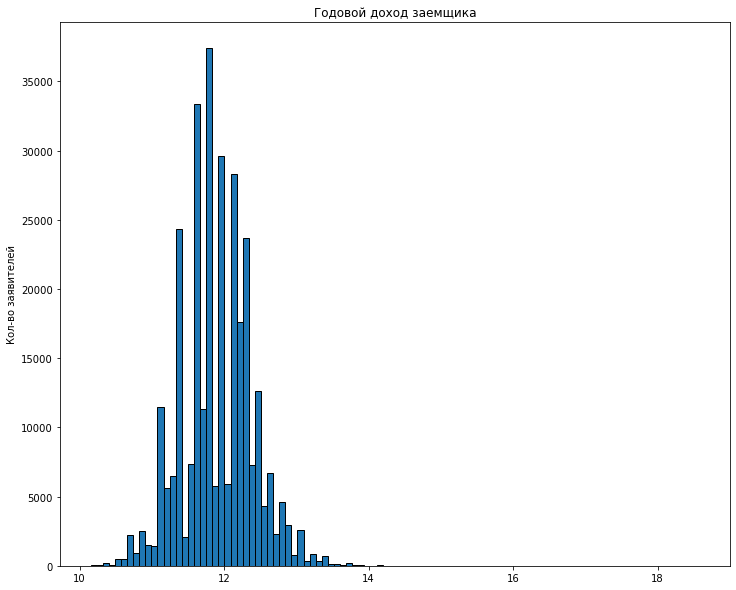

In [44]:
plt.figure(figsize = (12, 10))
plt.hist(np.log(df_train['AMT_INCOME_TOTAL']), bins = 100, edgecolor = 'k')
plt.title('Годовой доход заемщика')
plt.ylabel('Кол-во заявителей')

Text(0.5, 0, 'Годовой доход заемщика')

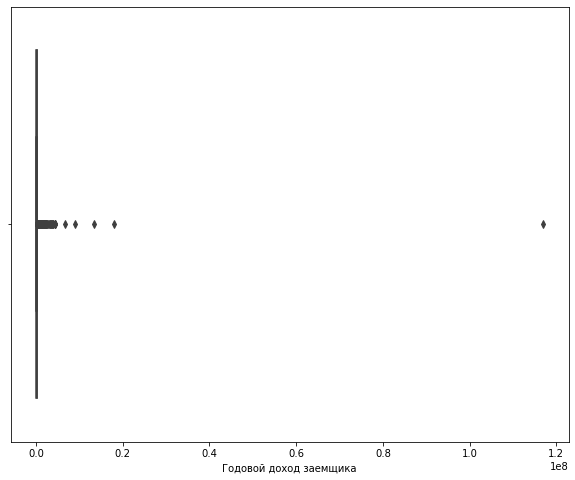

In [45]:
plt.figure(figsize = (10, 8))
sns.boxplot(x = df_train['AMT_INCOME_TOTAL'])
plt.xlabel('Годовой доход заемщика')

In [46]:
df_train[df_train['AMT_INCOME_TOTAL'] > 12000000]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
12840       114967       1         Cash loans           F            N   
203693      336147       0         Cash loans           M            Y   
246858      385674       0         Cash loans           M            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
12840                Y             1       117000000.0    562491.0   
203693               Y             2        18000090.0    675000.0   
246858               Y             0        13500000.0   1400503.5   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
12840       26194.5         454500.0   Unaccompanied               Working   
203693      69295.5         675000.0   Unaccompanied  Commercial associate   
246858     130945.5        1368000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
12840   Secondary / secondary special            Married  House / apartment   
203693  Secondary / secondary special            Married  House / apartment   
246858               Higher education            Married  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
12840                     0.010643       12615           -922   
203693                    0.030755       15704          -4961   
246858                    0.030755       13551           -280   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
12840             -6762.0            -3643          NaN           1   
203693            -3338.0            -4728          7.0           1   
246858            -3953.0            -4972         10.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
12840                1                0                 1           0   
203693               1                0                 1           0   
246858               1                1                 1           0   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
12840            0        Laborers              3.0                     2   
203693           0             NaN              4.0                     2   
246858           0             NaN              2.0                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
12840                             2                    TUESDAY   
203693                            2                   THURSDAY   
246858                            2                     SUNDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
12840                        14                           0   
203693                       22                           0   
246858                       12                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
12840                            0                            0   
203693                           0                            0   
246858                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
12840                        0                       0   
203693                       0                       0   
246858                       0                       0   

        LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  \
12840                         0  Business Entity Type 3      0.460809   
203693                        0  Business Entity Type 3      0.543417   
246858                        0  Business Entity Type 3           NaN   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
12840       0.113161      0.145543          0.1031            0.0947   
203693      0.788606           NaN             NaN               NaN   
246858      0.713507           NaN             NaN               NaN   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_A

Очень большой разрыв, я бы его убрала

In [47]:
# drop
df_train = df_train.drop(df_train[df_train['AMT_INCOME_TOTAL'] > 12000000].index)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461           -637            -3648.0   
1                    0.003541       16765          -1188            -1186.0   
2                    0.010032       19046           -225            -4260.0   
3                    0.008019       19005          -3039            -9833.0   
4                    0.028663       19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        



---


***Сумма кредита***

Text(0.5, 1.0, 'log Сумма кредита')

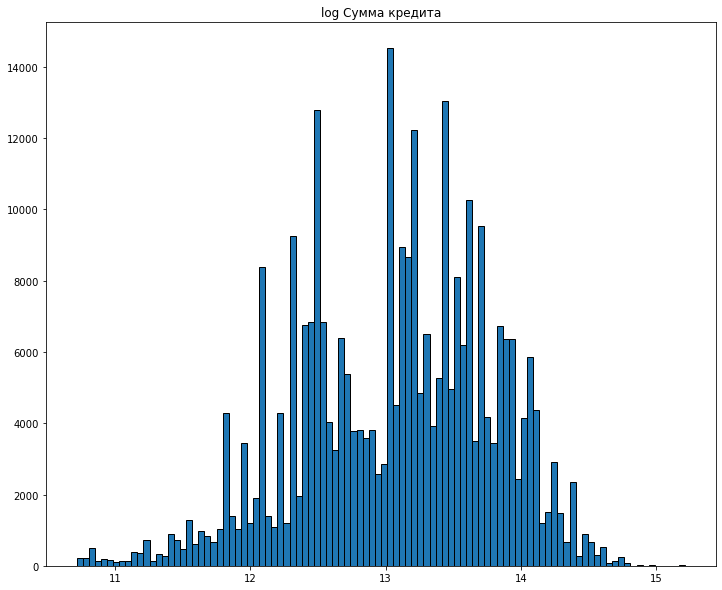

In [48]:
plt.figure(figsize = (12, 10))
plt.hist(np.log(df_train['AMT_CREDIT']), bins = 100, edgecolor = 'k')
plt.title('log Сумма кредита')

In [49]:
df_train[df_train['AMT_CREDIT'] > 4000000]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
14852       117337       0         Cash loans           M            N   
17948       120926       0         Cash loans           M            Y   
95571       210956       0         Cash loans           M            N   
110459      228135       0         Cash loans           M            N   
119681      238782       0         Cash loans           M            Y   
120757      240007       0         Cash loans           M            N   
133766      255139       0         Cash loans           F            Y   
186230      315893       1         Cash loans           F            N   
287732      433294       0         Cash loans           F            Y   
288455      434170       0         Cash loans           F            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
14852                Y             1          760846.5   4050000.0   
17948                N             2          783000.0   4050000.0   
95571                Y             0          430650.0   4031032.5   
110459               N             2          864900.0   4050000.0   
119681               Y             1          931365.0   4050000.0   
120757               N             0          587250.0   4050000.0   
133766               N             1         1307587.5   4050000.0   
186230               N             0          458550.0   4027680.0   
287732               N             1          405000.0   4050000.0   
288455               N             1          450000.0   4050000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
14852      146002.5        4050000.0   Unaccompanied  Commercial associate   
17948      258025.5        4050000.0   Unaccompanied  Commercial associate   
95571      102033.0        3712500.0   Unaccompanied               Working   
110459     102384.0        4050000.0   Unaccompanied  Commercial associate   
119681     102514.5        4050000.0   Unaccompanied  Commercial associate   
120757     106969.5        4050000.0   Unaccompanied  Commercial associate   
133766     100197.0        4050000.0   Unaccompanied  Commercial associate   
186230     106380.0        3600000.0   Unaccompanied  Commercial associate   
287732     102514.5        4050000.0   Unaccompanied  Commercial associate   
288455     106839.0        4050000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
14852                Higher education               Married   
17948                Higher education               Married   
95571                Higher education  Single / not married   
110459               Higher education               Married   
119681               Higher education               Married   
120757               Higher education               Married   
133766               Higher education               Married   
186230  Secondary / secondary special        Civil marriage   
287732               Higher education               Married   
288455               Higher education        Civil marriage   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
14852    Office apartment                    0.072508       12796   
17948   House / apartment                    0.009549       15176   
95571   House / apartment                    0.035792       16475   
110459  House / apartment                    0.025164       14940   
119681  House / apartment                    0.030755       12536   
120757  House / apartment                    0.046220       19893   
133766  House / apartment                    0.072508       15450   
186230  House / apartment                    0.010147       18907   
287732  House / apartment                    0.035792       11355   
288455  House / apartment                    0.035792       16609   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
14852           -1372            -3

Кредиты на  сумму > 400000 брали комерческие партнеры в основном, данные выглядят вполне адекватно

Text(0, 0.5, 'Сумма кредита')

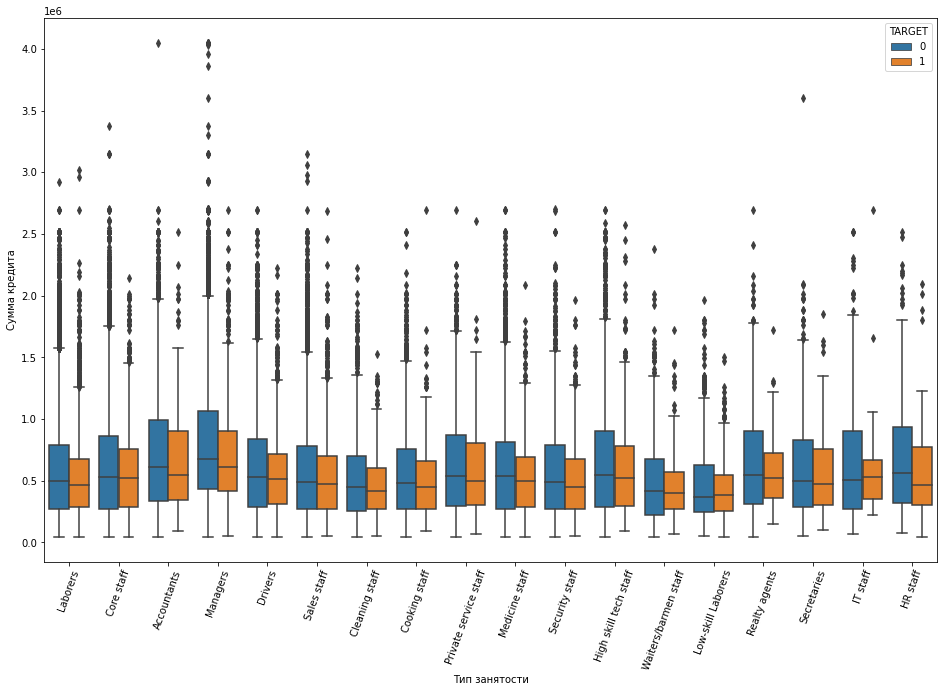

In [50]:
plt.figure(figsize=(16, 10))
sns.boxplot(x = 'OCCUPATION_TYPE', y = 'AMT_CREDIT',data = df_train, hue = 'TARGET')
plt.xticks(rotation = 70)
plt.xlabel('Тип занятости')
plt.ylabel('Сумма кредита')

Менеджеры и бухгалтеры чаще берут крудиты на крупные суммы, но есть большие выбросы, уберем самые значительные

In [51]:
df_train.query('OCCUPATION_TYPE == "Accountants" and AMT_CREDIT > 3500000')

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
287732      433294       0         Cash loans           F            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
287732               N             1          405000.0   4050000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
287732     102514.5        4050000.0   Unaccompanied  Commercial associate   

       NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
287732    Higher education            Married  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
287732                    0.035792       11355           -426   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
287732              -43.0            -1058          2.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
287732               1                1                 1           0   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
287732           0     Accountants              3.0                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
287732                            2                  WEDNESDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
287732                       17                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
287732                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
287732                       0                       0   

        LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  \
287732                        0  Business Entity Type 3      0.443685   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
287732      0.592158           NaN             NaN               NaN   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
287732                          NaN              NaN             NaN   

        ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
287732            NaN            NaN            NaN            NaN   

        LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
287732           NaN                   NaN             NaN   

        NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
287732                      NaN                NaN              NaN   

        BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
287732                NaN                           NaN               NaN   

        COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  \
287732              NaN             NaN             NaN             NaN   

        FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
287732             NaN            NaN                    NaN              NaN   

        NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
287732                       NaN                 NaN              NaN   

        BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
287732                NaN                           NaN               NaN   

        COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  \
287732              NaN             NaN             NaN             NaN   

        FLOORSMIN_MEDI  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  \
287732             NaN            NaN                    NaN              NaN   

        NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI FONDKAPREMONT_MODE  \
287732                       NaN                 NaN                NaN   

       HOUSETYPE_MODE  TOTALAREA_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  \
287732            NaN             NaN                NaN                 NaN   

        OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
287732                       3.

In [52]:
# drop
df_train = df_train.drop(df_train[ (df_train['AMT_CREDIT'] > 3500000) & (df_train['OCCUPATION_TYPE'] == "Accountants") ].index)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461           -637            -3648.0   
1                    0.003541       16765          -1188            -1186.0   
2                    0.010032       19046           -225            -4260.0   
3                    0.008019       19005          -3039            -9833.0   
4                    0.028663       19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [53]:
df_train.query('OCCUPATION_TYPE == "Cooking staff" and AMT_CREDIT > 2500000')

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
111122      228925       0         Cash loans           M            Y   
284161      429087       1         Cash loans           F            N   
284861      429909       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
111122               Y             0          139500.0   2517300.0   
284161               N             1          202500.0   2695500.0   
284861               Y             0          157500.0   2517300.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
111122      66532.5        2250000.0  Spouse, partner  Commercial associate   
284161      71235.0        2250000.0    Unaccompanied               Working   
284861      66532.5        2250000.0    Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
111122  Secondary / secondary special            Married  House / apartment   
284161  Secondary / secondary special            Married  House / apartment   
284861  Secondary / secondary special            Married  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
111122                    0.006233       19517          -3470   
284161                    0.020713       13972          -1229   
284861                    0.072508       16996          -1149   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
111122            -8321.0            -2933         15.0           1   
284161            -3600.0            -1490          NaN           1   
284861           -10776.0             -548          NaN           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
111122               1                0                 1           0   
284161               1                1                 1           0   
284861               1                0                 1           1   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
111122           0   Cooking staff              2.0                     2   
284161           0   Cooking staff              3.0                     3   
284861           0   Cooking staff              2.0                     1   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
111122                            2                  WEDNESDAY   
284161                            1                    TUESDAY   
284861                            1                     SUNDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
111122                       16                           0   
284161                       13                           0   
284861                       14                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
111122                           0                            0   
284161                           0                            0   
284861                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
111122                       0                       0   
284161                       0                       0   
284861                       0                       0   

        LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  \
111122                        0  Business Entity Type 3      0.869475   
284161                        0  Business Entity Type 3           NaN   
284861                        0           Trade: type 7           NaN   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
111122      0.727872      0.360613          0.0392               NaN   
284161      0.519984      0.350696          0.0990             0.000   
284861      0.661784      0.792264          0.2206             0.118   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUI

In [54]:
# drop
df_train = df_train.drop(df_train[ (df_train['AMT_CREDIT'] > 2500000) & (df_train['OCCUPATION_TYPE'] == "Cooking staff") ].index)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461           -637            -3648.0   
1                    0.003541       16765          -1188            -1186.0   
2                    0.010032       19046           -225            -4260.0   
3                    0.008019       19005          -3039            -9833.0   
4                    0.028663       19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [55]:
df_train.query('OCCUPATION_TYPE == "Realty agents" and AMT_CREDIT > 2500000')

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
22321      125982       0         Cash loans           F            N   

      FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
22321               Y             1          450000.0   2695500.0   

       AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
22321      71235.0        2250000.0   Unaccompanied          Working   

      NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
22321    Higher education     Civil marriage  House / apartment   

       REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
22321                    0.032561       16625          -5571   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
22321             -456.0             -188          NaN           1   

       FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
22321               1                0                 1           0   

       FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
22321           0   Realty agents              3.0                     1   

       REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
22321                            1                    TUESDAY   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
22321                       12                           0   

       REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
22321                           0                            0   

       REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
22321                       0                       0   

       LIVE_CITY_NOT_WORK_CITY ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  \
22321                        0           Realtor           NaN       0.72284   

       EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
22321      0.504681          0.1201             0.241   

       YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
22321                       0.9722           0.6328          0.0758   

       ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
22321         0.1332         0.1724           0.25         0.3333   

       LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
22321        0.1049                0.1042           0.162   

       NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
22321                   0.0309             0.0941           0.1145   

       BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
22321             0.0787                        0.9732            0.6472   

       COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  \
22321           0.0765          0.1611          0.1379          0.2917   

       FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
22321          0.3333         0.0503                 0.1139           0.1482   

       NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
22321                    0.0311                 0.0           0.1213   

       BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
22321              0.241                        0.9732            0.6377   

       COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  \
22321           0.0763            0.16          0.1379          0.2917   

       FLOORSMIN_MEDI  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  \
22321          0.3333         0.1067                  0.106           0.1749   

       NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI     FONDKAPREMONT_MODE  \
22321                    0.0311              0.0911  reg oper spec account   

       HOUSETYPE_MODE  TOTALAREA_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  \
22321  block of flats          0.1766       Stone, brick                  No   

       OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
22321                       0.0                       0.0   

       OBS_60_CNT_SOCIAL_CIRCLE  DE

In [56]:
# drop
df_train = df_train.drop(df_train[ (df_train['AMT_CREDIT'] > 2500000) & (df_train['OCCUPATION_TYPE'] == "Realty agents") ].index)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461           -637            -3648.0   
1                    0.003541       16765          -1188            -1186.0   
2                    0.010032       19046           -225            -4260.0   
3                    0.008019       19005          -3039            -9833.0   
4                    0.028663       19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [57]:
df_train.query('OCCUPATION_TYPE == "Secretaries" and AMT_CREDIT > 3000000')

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
104577      221360       0         Cash loans           M            Y   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
104577               N             0          468000.0   3600000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
104577      91138.5        3600000.0             NaN    State servant   

       NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
104577    Higher education            Married  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
104577                    0.010147       11202          -2590   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
104577            -1293.0            -3215          2.0           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
104577               1                1                 1           0   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
104577           0     Secretaries              2.0                     2   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
104577                            2                    TUESDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
104577                       12                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
104577                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
104577                       0                       0   

        LIVE_CITY_NOT_WORK_CITY    ORGANIZATION_TYPE  EXT_SOURCE_1  \
104577                        0  Security Ministries           NaN   

        EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
104577      0.283373       0.67383          0.0722            0.0585   

        YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
104577                       0.9906           0.8708           0.016   

        ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
104577           0.08          0.069         0.3333          0.375   

        LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  \
104577        0.0225                0.0588          0.0772   

        NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  \
104577                      0.0                0.0           0.0735   

        BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  \
104577             0.0607                        0.9906            0.8759   

        COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  \
104577           0.0161          0.0806           0.069          0.3333   

        FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  \
104577           0.375          0.023                 0.0643           0.0805   

        NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  \
104577                       0.0                 0.0           0.0729   

        BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  \
104577             0.0585                        0.9906            0.8725   

        COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  \
104577           0.0161            0.08           0.069          0.3333   

        FLOORSMIN_MEDI  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  \
104577           0.375         0.0229                 0.0599           0.0786   

        NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI FONDKAPREMONT_MODE  \
104577                       0.0                 0.0   org spec account   

        HOUSETYPE_MODE  TOTALAREA_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  \
104577  block of flats          0.0695       Stone, brick                  No   

        OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
104577                       0.0             

In [58]:
# drop
df_train = df_train.drop(df_train[ (df_train['AMT_CREDIT'] > 3000000) & (df_train['OCCUPATION_TYPE'] == "Secretaries") ].index)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461           -637            -3648.0   
1                    0.003541       16765          -1188            -1186.0   
2                    0.010032       19046           -225            -4260.0   
3                    0.008019       19005          -3039            -9833.0   
4                    0.028663       19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [59]:
df_train.query('OCCUPATION_TYPE == "Private service staff" and AMT_CREDIT > 2500000')

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
182818      311895       1         Cash loans           F            N   
253898      393790       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
182818               Y             0          315000.0   2606400.0   
253898               Y             0          540000.0   2695500.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
182818      84838.5        2250000.0             NaN  Commercial associate   
253898      71235.0        2250000.0   Unaccompanied  Commercial associate   

       NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
182818    Higher education  Single / not married  House / apartment   
253898    Higher education               Married  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
182818                    0.046220       18278          -1084   
253898                    0.072508       18046           -289   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
182818           -10167.0            -1809          NaN           1   
253898             -476.0            -1582          NaN           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
182818               1                0                 1           1   
253898               1                0                 1           0   

        FLAG_EMAIL        OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
182818           0  Private service staff              1.0   
253898           0  Private service staff              2.0   

        REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
182818                     1                            1   
253898                     1                            1   

       WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
182818                     MONDAY                       16   
253898                     MONDAY                        9   

        REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
182818                           0                           1   
253898                           0                           0   

        LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
182818                            1                       0   
253898                            0                       0   

        REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
182818                       0                        0   
253898                       0                        0   

             ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
182818  Business Entity Type 1      0.893882      0.627898           NaN   
253898                Services      0.764906      0.561535           NaN   

        APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
182818             NaN               NaN                          NaN   
253898             NaN               NaN                          NaN   

        YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
182818              NaN             NaN            NaN            NaN   
253898              NaN             NaN            NaN            NaN   

        FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  \
182818            NaN            NaN           NaN                   NaN   
253898            NaN            NaN           NaN                   NaN   

        LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  \
182818             NaN                      NaN                NaN   
253898             NaN                      NaN                NaN   

        APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  \
182818              NaN                NaN                           NaN   
253898              NaN                NaN                           NaN   

        YEARS_BUILD_MODE  COMMON

In [60]:
# drop
df_train = df_train.drop(df_train[ (df_train['AMT_CREDIT'] > 2500000) & (df_train['OCCUPATION_TYPE'] == "Private service staff") ].index)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461           -637            -3648.0   
1                    0.003541       16765          -1188            -1186.0   
2                    0.010032       19046           -225            -4260.0   
3                    0.008019       19005          -3039            -9833.0   
4                    0.028663       19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [61]:
df_train.query('OCCUPATION_TYPE == "IT staff" and AMT_CREDIT > 2500000')

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
50062       157951       0         Cash loans           M            Y   
137687      259679       0         Cash loans           M            Y   
193640      324546       1         Cash loans           M            Y   
219824      354663       0         Cash loans           M            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
50062                N             0          225000.0   2517300.0   
137687               Y             0          225000.0   2517300.0   
193640               N             0          450000.0   2695500.0   
219824               N             0          352350.0   2517300.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
50062       66532.5        2250000.0  Spouse, partner  Commercial associate   
137687      66402.0        2250000.0    Unaccompanied               Working   
193640      71235.0        2250000.0    Unaccompanied  Commercial associate   
219824      66532.5        2250000.0    Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
50062                Higher education     Civil marriage  House / apartment   
137687               Higher education            Married  House / apartment   
193640  Secondary / secondary special            Married   Office apartment   
219824  Secondary / secondary special     Civil marriage  House / apartment   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
50062                     0.010032       10405           -899   
137687                    0.007330       12055          -2476   
193640                    0.046220       13233           -530   
219824                    0.072508        9862          -2931   

        DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  \
50062             -4919.0            -3081         19.0           1   
137687            -2456.0            -4328          1.0           1   
193640            -6753.0            -4054          0.0           1   
219824            -4629.0            -2517          NaN           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
50062                1                0                 1           0   
137687               1                0                 1           0   
193640               1                0                 1           1   
219824               1                1                 1           1   

        FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
50062            0        IT staff              2.0                     2   
137687           0        IT staff              2.0                     2   
193640           0        IT staff              2.0                     1   
219824           0        IT staff              2.0                     1   

        REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
50062                             2                   SATURDAY   
137687                            2                   THURSDAY   
193640                            1                    TUESDAY   
219824                            1                     MONDAY   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
50062                         6                           0   
137687                       14                           0   
193640                       17                           0   
219824                       15                           0   

        REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
50062                            0                            0   
137687                           0                            0   
193640                           0                            0   
219824                           0                            0   

        REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  \
50062              

In [62]:
# drop
df_train = df_train.drop(df_train[ (df_train['AMT_CREDIT'] > 2500000) & (df_train['OCCUPATION_TYPE'] == "IT staff") ].index)
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801        9461           -637            -3648.0   
1                    0.003541       16765          -1188            -1186.0   
2                    0.010032       19046           -225            -4260.0   
3                    0.008019       19005          -3039            -9833.0   
4                    0.028663       19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [63]:
df_train.query('OCCUPATION_TYPE == "HR staff" and AMT_CREDIT > 2000000')

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
64591       174905       0         Cash loans           M            Y   
106547      223623       0         Cash loans           F            N   
131092      252045       1         Cash loans           F            N   
137771      259774       0         Cash loans           F            N   
139822      262134       0         Cash loans           F            N   
170652      297777       0         Cash loans           F            N   
211210      344754       0         Cash loans           F            N   
249547      388736       1         Cash loans           M            Y   
264451      406262       0         Cash loans           F            N   
267835      410332       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
64591                Y             1          469800.0   2475000.0   
106547               N             0          157500.0   2168181.0   
131092               Y             0          450000.0   2013840.0   
137771               Y             0          211500.0   2064186.0   
139822               Y             0          202500.0   2183355.0   
170652               N             2          198900.0   2025000.0   
211210               Y             0          292500.0   2517300.0   
249547               N             0          270000.0   2097058.5   
264451               N             0          247500.0   2250000.0   
267835               Y             0          315000.0   2199528.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
64591       65290.5        2475000.0   Unaccompanied  Commercial associate   
106547      65736.0        1980000.0   Unaccompanied               Working   
131092      83110.5        1800000.0   Unaccompanied  Commercial associate   
137771      56763.0        1845000.0   Unaccompanied               Working   
139822      60169.5        1822500.0   Unaccompanied               Working   
170652      53419.5        2025000.0   Unaccompanied               Working   
211210      69354.0        2250000.0   Unaccompanied  Commercial associate   
249547      61402.5        1894500.0   Unaccompanied               Working   
264451      59485.5        2250000.0   Unaccompanied               Working   
267835      60615.0        1836000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
64591                Higher education               Married   
106547  Secondary / secondary special               Married   
131092               Higher education               Married   
137771               Higher education               Married   
139822  Secondary / secondary special             Separated   
170652               Higher education             Separated   
211210               Higher education  Single / not married   
249547               Higher education  Single / not married   
264451               Higher education               Married   
267835               Higher education  Single / not married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
64591   House / apartment                    0.025164       11384   
106547  House / apartment                    0.003818       20746   
131092  House / apartment                    0.005084       12396   
137771  House / apartment                    0.035792       16332   
139822  House / apartment                    0.032561       20783   
170652  House / apartment                    0.018029       14145   
211210  House / apartment                    0.032561        9224   
249547  House / apartment                    0.018801        9839   
264451  House / apartment                    0.028663       16192   
267835  House / apartment                    0.046220        8825   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
64591           -3680             -

In [64]:
# изначально было (307511, 122)
df_train.shape

(307479, 207)



---


***Количество отработанных дней***

In [65]:
df_train['DAYS_EMPLOYED']

0           -637
1          -1188
2           -225
3          -3039
4          -3038
           ...  
307506      -236
307507    365243
307508     -7921
307509     -4786
307510     -1262
Name: DAYS_EMPLOYED, Length: 307479, dtype: int64

Text(0, 0.5, 'Кол-во заявителей')

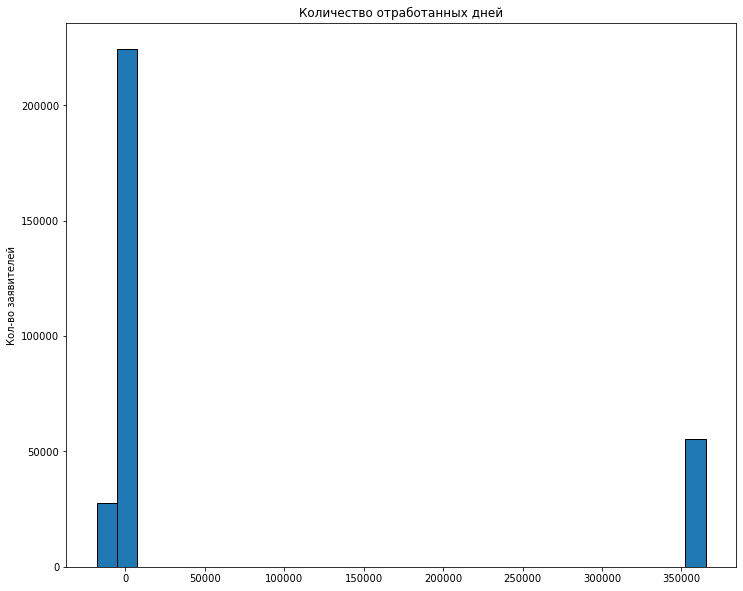

In [66]:
plt.figure(figsize = (12, 10))
plt.hist(df_train['DAYS_EMPLOYED'], bins = 30, edgecolor = 'k')
plt.title('Количество отработанных дней')
plt.ylabel('Кол-во заявителей')

Text(0.5, 0, 'Количество отработанных дней')

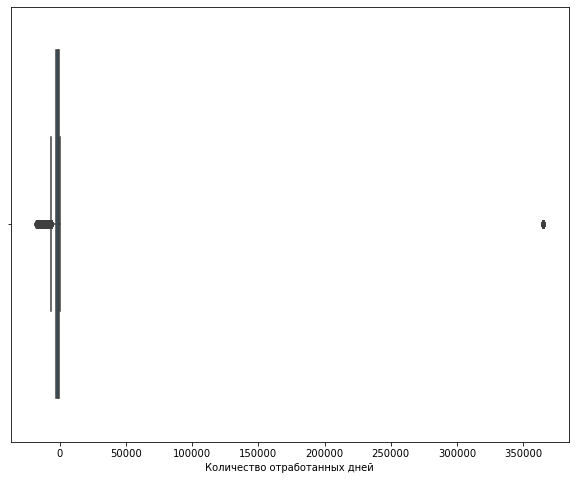

In [67]:
plt.figure(figsize = (10,8))
sns.boxplot(x = df_train['DAYS_EMPLOYED'])
plt.xlabel('Количество отработанных дней')

Есть выброс

In [68]:
print(df_train['DAYS_EMPLOYED'].max())
print(df_train['DAYS_EMPLOYED'].min())

365243
-17912


In [69]:
df_train[df_train['DAYS_EMPLOYED'] >= 365243]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
8           100011       0         Cash loans           F            N   
11          100015       0         Cash loans           F            N   
23          100027       0         Cash loans           F            N   
38          100045       0         Cash loans           F            N   
43          100050       0         Cash loans           F            N   
...            ...     ...                ...         ...          ...   
307469      456209       0         Cash loans           F            N   
307483      456227       0         Cash loans           F            N   
307487      456231       0         Cash loans           M            N   
307505      456249       0         Cash loans           F            N   
307507      456252       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
8                    Y             0        112500.000   1019610.0   
11                   Y             0         38419.155    148365.0   
23                   Y             0         83250.000    239850.0   
38                   Y             0         99000.000    247275.0   
43                   Y             0        108000.000    746280.0   
...                ...           ...               ...         ...   
307469               Y             0        202500.000    703728.0   
307483               Y             0         99000.000    247275.0   
307487               Y             0        117000.000   1071909.0   
307505               Y             0        112500.000    225000.0   
307507               Y             0         72000.000    269550.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
8           33826.5         913500.0        Children        Pensioner   
11          10678.5         135000.0        Children        Pensioner   
23          23850.0         225000.0   Unaccompanied        Pensioner   
38          17338.5         225000.0   Unaccompanied        Pensioner   
43          42970.5         675000.0   Unaccompanied        Pensioner   
...             ...              ...             ...              ...   
307469      29943.0         607500.0   Unaccompanied        Pensioner   
307483      16479.0         225000.0   Unaccompanied        Pensioner   
307487      31473.0         936000.0   Unaccompanied        Pensioner   
307505      22050.0         225000.0   Unaccompanied        Pensioner   
307507      12001.5         225000.0   Unaccompanied        Pensioner   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
8       Secondary / secondary special               Married   
11      Secondary / secondary special               Married   
23      Secondary / secondary special               Married   
38      Secondary / secondary special               Married   
43                   Higher education  Single / not married   
...                               ...                   ...   
307469  Secondary / secondary special  Single / not married   
307483  Secondary / secondary special             Separated   
307487  Secondary / secondary special               Married   
307505  Secondary / secondary special  Single / not married   
307507  Secondary / secondary special                 Widow   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
8       House / apartment                    0.018634       20099   
11      House / apartment                    0.015221       20417   
23      House / apartment                    0.006296       24827   
38      House / apartment                    0.006207       23920   
43      House / apartment                    0.010966       23548   
...                   ...                         ...         ...   
307469  House / apartment                    0.031329       22414   
307483  House / apartment                    0.007330       24911   
307487  House / apartme

55373 / 307511 * 100 = 18.006835527834777 <---  отношение ко всему датафрейму

Эти данные состовляют 18% от всего df. Возможно такие значения в 1000 лет лучше заменить на нули

In [70]:
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].replace(365243, np.nan)
df_train['DAYS_EMPLOYED'] = df_train['DAYS_EMPLOYED'].fillna(0)

In [71]:
df_train

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0           100002       1         Cash loans           M            N   
1           100003       0         Cash loans           F            N   
2           100004       0    Revolving loans           M            Y   
3           100006       0         Cash loans           F            N   
4           100007       0         Cash loans           M            N   
...            ...     ...                ...         ...          ...   
307506      456251       0         Cash loans           M            N   
307507      456252       0         Cash loans           F            N   
307508      456253       0         Cash loans           F            N   
307509      456254       1         Cash loans           F            N   
307510      456255       0         Cash loans           F            N   

       FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                    Y             0          202500.0    406597.5   
1                    N             0          270000.0   1293502.5   
2                    Y             0           67500.0    135000.0   
3                    Y             0          135000.0    312682.5   
4                    Y             0          121500.0    513000.0   
...                ...           ...               ...         ...   
307506               N             0          157500.0    254700.0   
307507               Y             0           72000.0    269550.0   
307508               Y             0          153000.0    677664.0   
307509               Y             0          171000.0    370107.0   
307510               N             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE  \
0           24700.5         351000.0   Unaccompanied               Working   
1           35698.5        1129500.0          Family         State servant   
2            6750.0         135000.0   Unaccompanied               Working   
3           29686.5         297000.0   Unaccompanied               Working   
4           21865.5         513000.0   Unaccompanied               Working   
...             ...              ...             ...                   ...   
307506      27558.0         225000.0   Unaccompanied               Working   
307507      12001.5         225000.0   Unaccompanied             Pensioner   
307508      29979.0         585000.0   Unaccompanied               Working   
307509      20205.0         319500.0   Unaccompanied  Commercial associate   
307510      49117.5         675000.0   Unaccompanied  Commercial associate   

                  NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0       Secondary / secondary special  Single / not married   
1                    Higher education               Married   
2       Secondary / secondary special  Single / not married   
3       Secondary / secondary special        Civil marriage   
4       Secondary / secondary special  Single / not married   
...                               ...                   ...   
307506  Secondary / secondary special             Separated   
307507  Secondary / secondary special                 Widow   
307508               Higher education             Separated   
307509  Secondary / secondary special               Married   
307510               Higher education               Married   

        NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0       House / apartment                    0.018801        9461   
1       House / apartment                    0.003541       16765   
2       House / apartment                    0.010032       19046   
3       House / apartment                    0.008019       19005   
4       House / apartment                    0.028663       19932   
...                   ...                         ...         ...   
307506       With parents                    0.032561        9327   
307507  House / apartment       

In [72]:
df_train.shape

(307479, 207)

# **EDA Part 1.1**
# **Корреляция значений**

In [73]:
correlation = df_train.corr()['TARGET'].sort_values()
print(f'Имеют наибольшую корреляцию:\n {correlation.tail(20)}')
print('-' * 50)
print(f'Имеют наименьшую корреляцию:\n {correlation.head(20)}')

Имеют наибольшую корреляцию:
 CNT_FAM_MEMBERS                0.009304
CNT_CHILDREN                   0.019248
AMT_REQ_CREDIT_BUREAU_YEAR     0.019949
FLAG_WORK_PHONE                0.028525
DEF_60_CNT_SOCIAL_CIRCLE       0.031293
DEF_30_CNT_SOCIAL_CIRCLE       0.032273
LIVE_CITY_NOT_WORK_CITY        0.032516
RATE_INTEREST_PRIMARY          0.032551
OWN_CAR_AGE                    0.037471
DAYS_REGISTRATION              0.042007
FLAG_DOCUMENT_3                0.044349
REG_CITY_NOT_LIVE_CITY         0.044417
FLAG_EMP_PHONE                 0.045967
DAYS_EMPLOYED                  0.046026
REG_CITY_NOT_WORK_CITY         0.051000
DAYS_ID_PUBLISH                0.051442
DAYS_LAST_PHONE_CHANGE         0.055175
REGION_RATING_CLIENT           0.058905
REGION_RATING_CLIENT_W_CITY    0.060941
TARGET                         1.000000
Name: TARGET, dtype: float64
--------------------------------------------------
Имеют наименьшую корреляцию:
 EXT_SOURCE_3                 -0.178835
EXT_SOURCE_2         

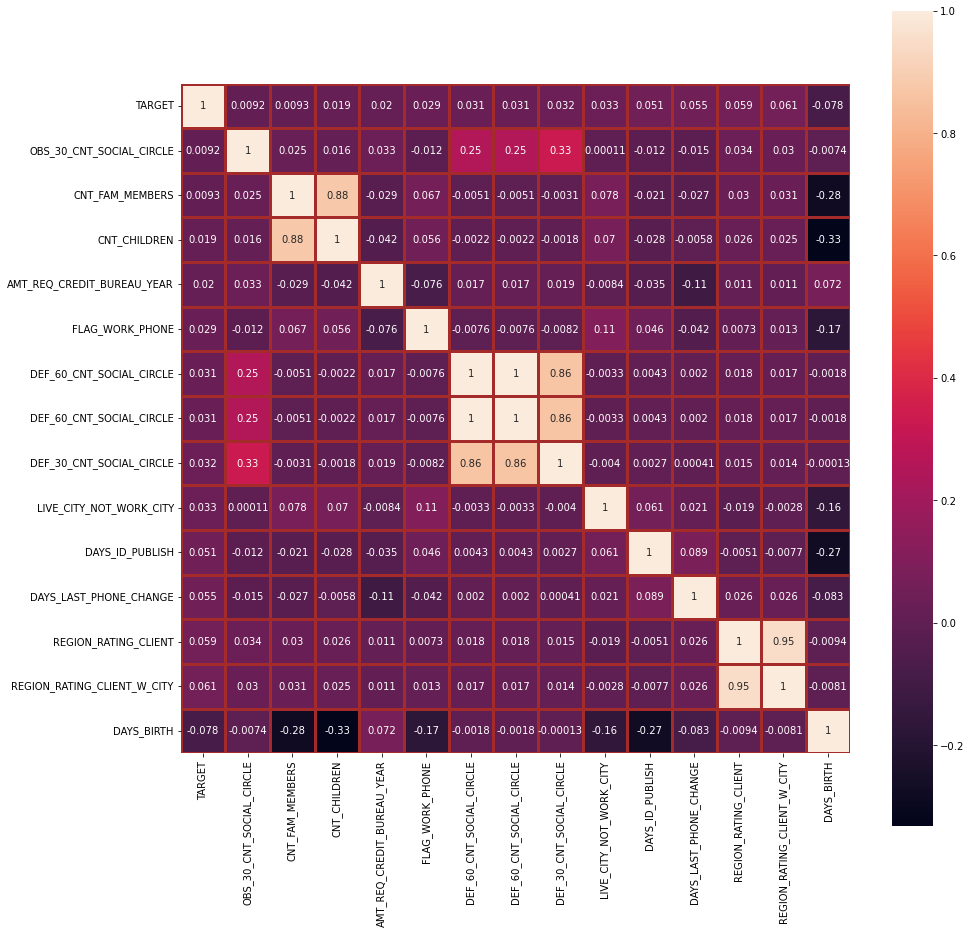

In [74]:
columns = df_train[['TARGET',
                    'OBS_30_CNT_SOCIAL_CIRCLE', 
                    'CNT_FAM_MEMBERS', 
                    'CNT_CHILDREN', 
                    'AMT_REQ_CREDIT_BUREAU_YEAR', 
                    'FLAG_WORK_PHONE', 
                    'DEF_60_CNT_SOCIAL_CIRCLE', 
                    'DEF_60_CNT_SOCIAL_CIRCLE', 
                    'DEF_30_CNT_SOCIAL_CIRCLE', 
                    'LIVE_CITY_NOT_WORK_CITY',
                    'DAYS_ID_PUBLISH', 
                    'DAYS_LAST_PHONE_CHANGE', 
                    'REGION_RATING_CLIENT', 
                    'REGION_RATING_CLIENT_W_CITY', 
                    'DAYS_BIRTH']].copy()
col = columns.corr()
plt.figure(figsize = (15, 15))
sns.heatmap(col, annot = True, fmt = '.2g', square = True, linewidths=3, linecolor='brown')
plt.show()

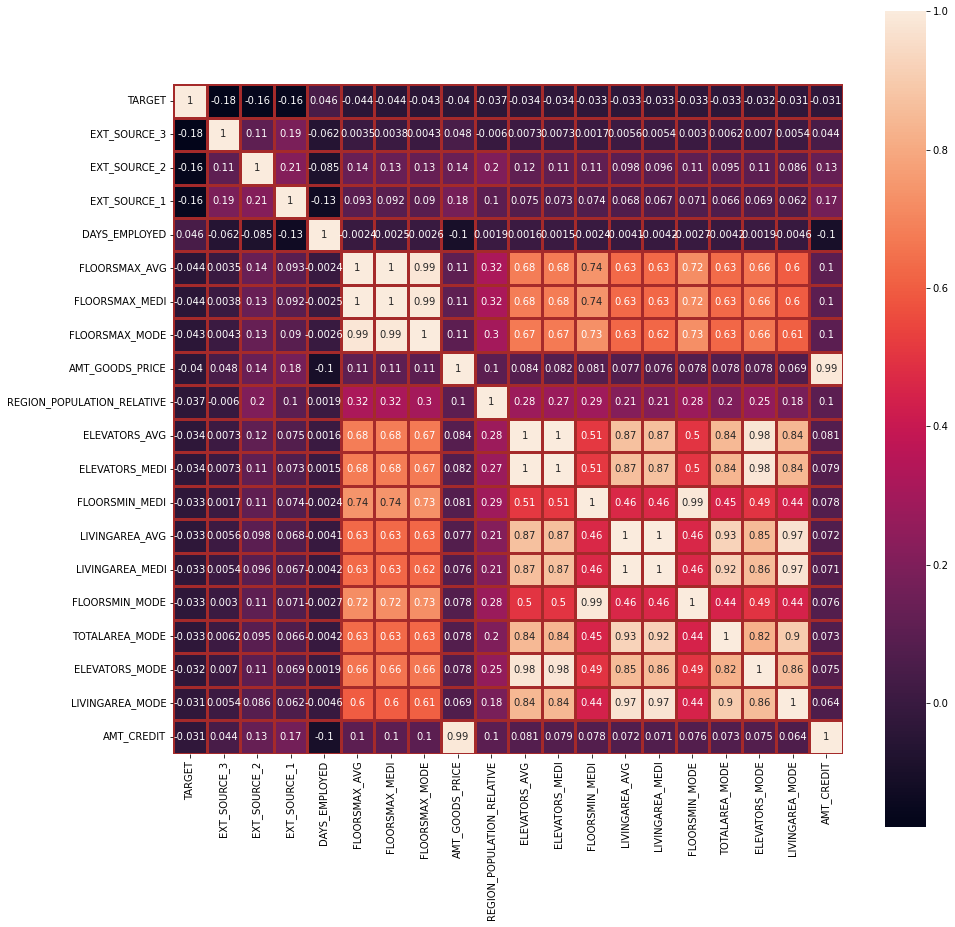

In [75]:
col_corr = df_train[['TARGET',
                     'EXT_SOURCE_3',
                     'EXT_SOURCE_2',
                     'EXT_SOURCE_1',
                     'DAYS_EMPLOYED',
                     'FLOORSMAX_AVG',
                     'FLOORSMAX_MEDI',
                     'FLOORSMAX_MODE',
                     'AMT_GOODS_PRICE',
                     'REGION_POPULATION_RELATIVE',
                     'ELEVATORS_AVG',
                     'ELEVATORS_MEDI',
                     'FLOORSMIN_MEDI',
                     'LIVINGAREA_AVG',
                     'LIVINGAREA_MEDI',
                     'FLOORSMIN_MODE',
                     'TOTALAREA_MODE',
                     'ELEVATORS_MODE',
                     'LIVINGAREA_MODE',
                     'AMT_CREDIT']].copy()

col = col_corr.corr()
plt.figure(figsize = (15, 15))
sns.heatmap(col, annot = True, fmt = '.2g', square = True, linewidths=3, linecolor='brown')
plt.show()

Здесь интерес представляет только количесвто отработанных дней (DAYS_EMPLOYED), при этом имеет не высокую корреляцию

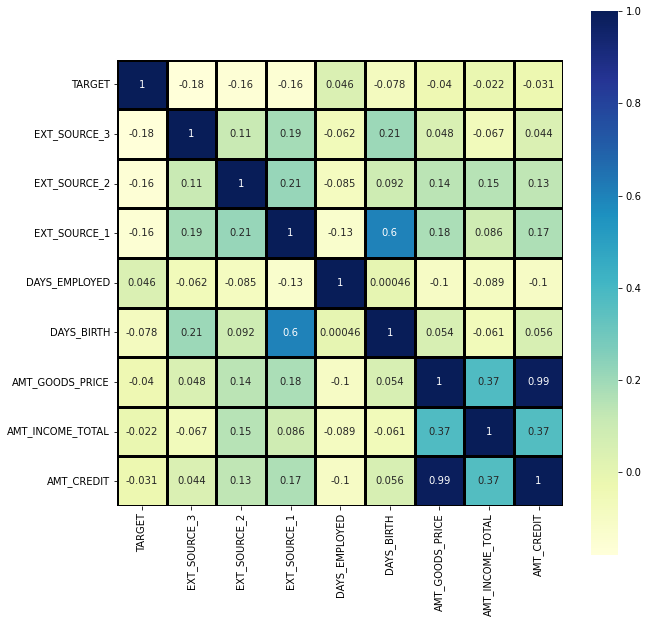

In [76]:
columns_corr = df_train[['TARGET',
                    'EXT_SOURCE_3',
                    'EXT_SOURCE_2',
                    'EXT_SOURCE_1',
                    'DAYS_EMPLOYED',
                    'DAYS_BIRTH',
                    'AMT_GOODS_PRICE',
                    'AMT_INCOME_TOTAL',
                    'AMT_CREDIT'
                    ]].copy()

columns_corr = columns_corr.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(columns_corr, annot = True, fmt = '.2g', square = True, cmap="YlGnBu", linewidths=3, linecolor='black')
plt.show()      

Интерсная зависимость между данными , но данные не завязаны на целевой перменной

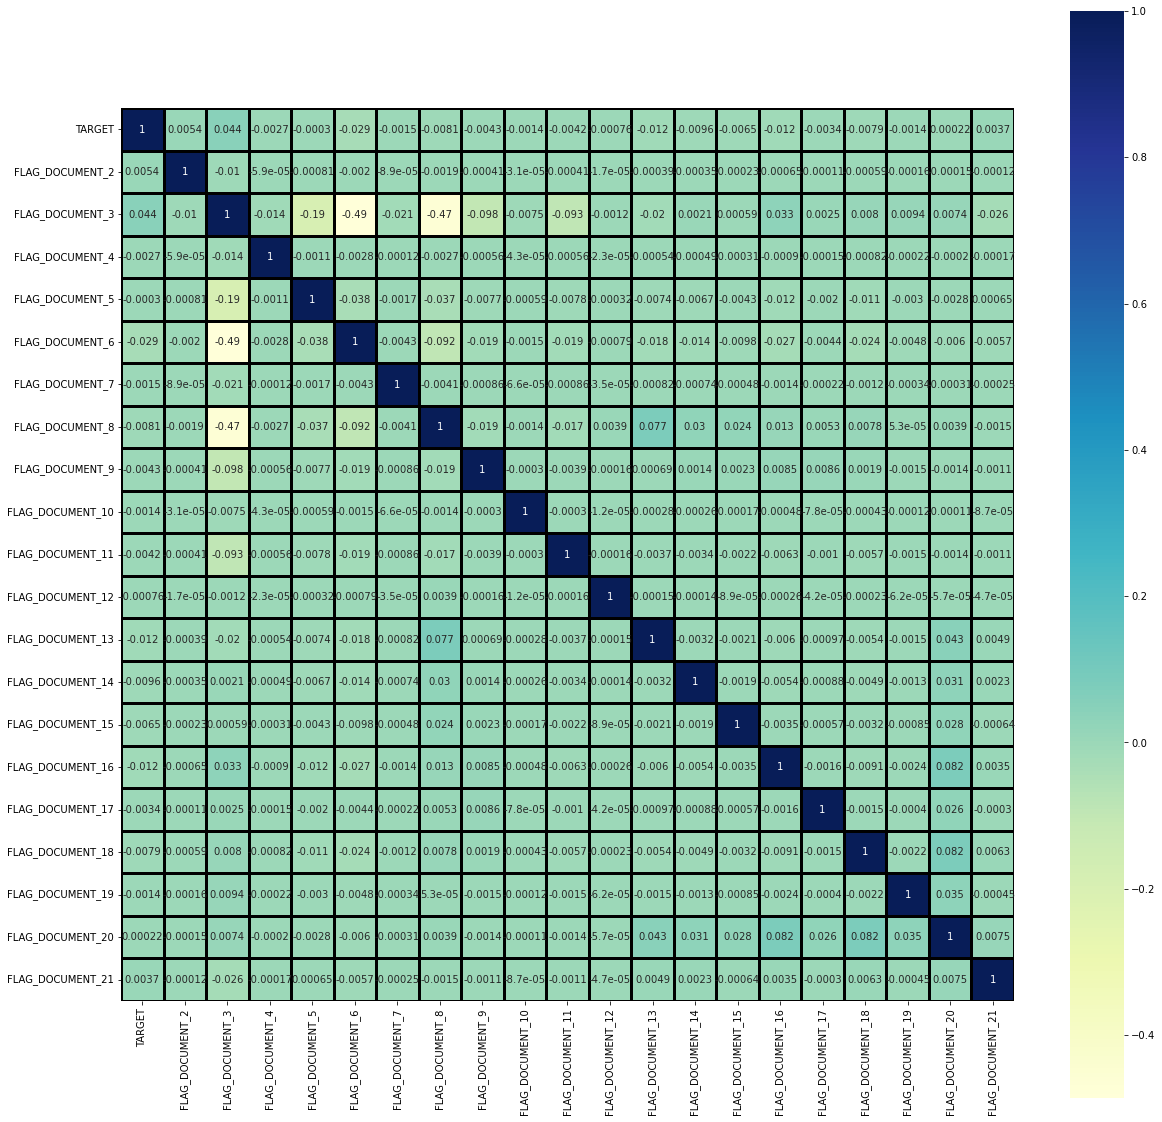

In [77]:
columns_corr = df_train[['TARGET',
                         'FLAG_DOCUMENT_2',
                         'FLAG_DOCUMENT_3',
                         'FLAG_DOCUMENT_4',
                         'FLAG_DOCUMENT_5',
                         'FLAG_DOCUMENT_6',
                         'FLAG_DOCUMENT_7',
                         'FLAG_DOCUMENT_8',
                         'FLAG_DOCUMENT_9',
                         'FLAG_DOCUMENT_10',
                         'FLAG_DOCUMENT_11',
                         'FLAG_DOCUMENT_12',
                         'FLAG_DOCUMENT_13',
                         'FLAG_DOCUMENT_14',
                         'FLAG_DOCUMENT_15',
                         'FLAG_DOCUMENT_16',
                         'FLAG_DOCUMENT_17',
                         'FLAG_DOCUMENT_18','FLAG_DOCUMENT_19',
                         'FLAG_DOCUMENT_20',
                         'FLAG_DOCUMENT_21'
                         ]].copy()

columns_corr = columns_corr.corr()
plt.figure(figsize = (20, 20))
sns.heatmap(columns_corr, annot = True, fmt = '.2g', square = True, cmap="YlGnBu", linewidths=3, linecolor='black')
plt.show()  

In [78]:
correlation = columns_corr.corr()['TARGET'].sort_values()
print(f'Имеют наибольшую корреляцию:\n {correlation.tail(5)}')
print('-' * 50)
print(f'Имеют наименьшую корреляцию:\n {correlation.head(5)}')

Имеют наибольшую корреляцию:
 FLAG_DOCUMENT_21   -0.040263
FLAG_DOCUMENT_5    -0.037630
FLAG_DOCUMENT_2    -0.035670
FLAG_DOCUMENT_3     0.101170
TARGET              1.000000
Name: TARGET, dtype: float64
--------------------------------------------------
Имеют наименьшую корреляцию:
 FLAG_DOCUMENT_6    -0.078157
FLAG_DOCUMENT_13   -0.074236
FLAG_DOCUMENT_16   -0.071588
FLAG_DOCUMENT_14   -0.067580
FLAG_DOCUMENT_20   -0.065524
Name: TARGET, dtype: float64


Здесь же корелляция значительная, поэтому отберем несколько фичей(FLAG_DOCUMENT_6, FLAG_DOCUMENT_13, FLAG_DOCUMENT_16, 
FLAG_DOCUMENT_14, FLAG_DOCUMENT_20)

In [79]:
df_train = df_train.drop(df_train[['FLAG_DOCUMENT_2',
                                    'FLAG_DOCUMENT_3',
                                    'FLAG_DOCUMENT_4',
                                    'FLAG_DOCUMENT_5',
                                    'FLAG_DOCUMENT_7',
                                    'FLAG_DOCUMENT_8',
                                    'FLAG_DOCUMENT_9',
                                    'FLAG_DOCUMENT_10',	
                                    'FLAG_DOCUMENT_11',
                                    'FLAG_DOCUMENT_12',
                                    'FLAG_DOCUMENT_15',
                                    'FLAG_DOCUMENT_17',
                                    'FLAG_DOCUMENT_18',
                                    'FLAG_DOCUMENT_19',
                                    'FLAG_DOCUMENT_21']], axis = 1)
print(df_train.shape)

(307479, 192)


# **EDA Part 1.2**
# **Кодирование категориальных переменных**

In [80]:
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE                      2
CODE_GENDER                             2
FLAG_OWN_CAR                            2
FLAG_OWN_REALTY                         2
NAME_TYPE_SUITE                         7
NAME_INCOME_TYPE                        8
NAME_EDUCATION_TYPE                     5
NAME_FAMILY_STATUS                      5
NAME_HOUSING_TYPE                       6
OCCUPATION_TYPE                        18
WEEKDAY_APPR_PROCESS_START              7
ORGANIZATION_TYPE                      58
FONDKAPREMONT_MODE                      4
HOUSETYPE_MODE                          3
WALLSMATERIAL_MODE                      7
EMERGENCYSTATE_MODE                     2
NAME_CONTRACT_TYPE_previous             4
WEEKDAY_APPR_PROCESS_START_previous     7
FLAG_LAST_APPL_PER_CONTRACT             2
NAME_CASH_LOAN_PURPOSE                 25
NAME_CONTRACT_STATUS                    4
NAME_PAYMENT_TYPE                       4
CODE_REJECT_REASON                      9
NAME_TYPE_SUITE_previous          

In [81]:
le = LabelEncoder()

for column in df_train:
    df_train_LE = df_train
    if df_train_LE[column].dtype == 'object': # тип данных
        print(column, len(df_train_LE[column].unique())) # определение уникальных столбцов
        df_train_LE[column] = le.fit_transform(df_train_LE[column]) # обучение энкодера

NAME_CONTRACT_TYPE 2
CODE_GENDER 2
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
NAME_TYPE_SUITE 8
NAME_INCOME_TYPE 8
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 5
NAME_HOUSING_TYPE 6
OCCUPATION_TYPE 19
WEEKDAY_APPR_PROCESS_START 7
ORGANIZATION_TYPE 58
FONDKAPREMONT_MODE 5
HOUSETYPE_MODE 4
WALLSMATERIAL_MODE 8
EMERGENCYSTATE_MODE 3
NAME_CONTRACT_TYPE_previous 4
WEEKDAY_APPR_PROCESS_START_previous 7
FLAG_LAST_APPL_PER_CONTRACT 2
NAME_CASH_LOAN_PURPOSE 25
NAME_CONTRACT_STATUS 4
NAME_PAYMENT_TYPE 4
CODE_REJECT_REASON 9
NAME_TYPE_SUITE_previous 8
NAME_CLIENT_TYPE 4
NAME_GOODS_CATEGORY 27
NAME_PORTFOLIO 5
NAME_PRODUCT_TYPE 3
CHANNEL_TYPE 8
NAME_SELLER_INDUSTRY 11
NAME_YIELD_GROUP 5
PRODUCT_COMBINATION 18
NAME_CONTRACT_STATUS_POS_CASH 6
NAME_CONTRACT_STATUS_credit 7
CREDIT_ACTIVE 4
CREDIT_CURRENCY 4
CREDIT_TYPE 13


In [82]:
df_train_LE.head(3)

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1             0          202500.0    406597.5      24700.5   
1                0             0          270000.0   1293502.5      35698.5   
2                1             0           67500.0    135000.0       6750.0   

   AMT_GOODS_PRICE  NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0         351000.0                6                 7                    4   
1        1129500.0                1                 4                    1   
2         135000.0                6                 7                    4   

   NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0                   3                  1                    0.018801   
1                   1                  1                    0.003541   
2                   3                  1                    0.010032   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0        9461         -637.0            -3648.0            -2120          NaN   
1       16765        -1188.0            -1186.0             -291          NaN   
2       19046         -225.0            -4260.0            -2531         26.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           1   
1           1               1                0                 1           1   
2           1               1                1                 1           1   

   FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           0                8              1.0                     2   
1           0                3              2.0                     1   
2           0                8              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  \
0                            2                           6   
1                            1                           1   
2                            2                           1   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0                            0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  \
0                       0                       0                        0   
1                       0                       0                        0   
2                       0                       0                        0   

   ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
0                  5      0.083037      0.262949      0.139376   
1                 39      0.311267      0.622246           NaN   
2                 11           NaN      0.555912      0.729567   

   APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
0          0.0247            0.0369                       0.9722   
1          0.0959            0.0529                       0.9851   
2             NaN               NaN                          NaN   

   YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
0           0.6192          0.0143           0.00         0.0690   
1           0.7960          0.0605           0.08         0.0345   
2              NaN             NaN            NaN            NaN   

 

# **EDA Part 1.3**
# **Нулевые значения**

In [83]:
pd.DataFrame(df_train_LE.isnull().sum().sort_values(ascending = False))[:20]

0
RATE_INTEREST_PRIVILEGED  306383
RATE_INTEREST_PRIMARY     306383
COMMONAREA_MODE           214844
COMMONAREA_AVG            214844
COMMONAREA_MEDI           214844
NONLIVINGAPARTMENTS_MODE  213494
NONLIVINGAPARTMENTS_MEDI  213494
NONLIVINGAPARTMENTS_AVG   213494
LIVINGAPARTMENTS_MODE     210179
LIVINGAPARTMENTS_AVG      210179
LIVINGAPARTMENTS_MEDI     210179
FLOORSMIN_MEDI            208622
FLOORSMIN_AVG             208622
FLOORSMIN_MODE            208622
YEARS_BUILD_MODE          204469
YEARS_BUILD_MEDI          204469
YEARS_BUILD_AVG           204469
AMT_CREDIT_MAX_OVERDUE    204401
OWN_CAR_AGE               202913
AMT_ANNUITY_bureau        202726

In [84]:
df_train_LE.dtypes.value_counts()

float64    106
int64       49
int32       37
dtype: int64

Пропущенных данных очень много, воспользуемся Simple Imputer, заполним значение модальным значением

In [85]:
imputer = SimpleImputer(strategy = 'most_frequent', missing_values = np.nan)

for column in df_train_LE.columns:
      df_train_LE[[column]] = imputer.fit_transform(df_train_LE[[column]])

In [86]:
df_train_LE.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1             0          202500.0    406597.5      24700.5   
1                0             0          270000.0   1293502.5      35698.5   
2                1             0           67500.0    135000.0       6750.0   
3                1             0          135000.0    312682.5      29686.5   
4                1             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  \
0         351000.0                6                 7                    4   
1        1129500.0                1                 4                    1   
2         135000.0                6                 7                    4   
3         297000.0                6                 7                    4   
4         513000.0                6                 7                    4   

   NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0                   3                  1                    0.018801   
1                   1                  1                    0.003541   
2                   3                  1                    0.010032   
3                   0                  1                    0.008019   
4                   3                  1                    0.028663   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0        9461         -637.0            -3648.0            -2120          7.0   
1       16765        -1188.0            -1186.0             -291          7.0   
2       19046         -225.0            -4260.0            -2531         26.0   
3       19005        -3039.0            -9833.0            -2437          7.0   
4       19932        -3038.0            -4311.0            -3458          7.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           1   
1           1               1                0                 1           1   
2           1               1                1                 1           1   
3           1               1                0                 1           0   
4           1               1                0                 1           0   

   FLAG_EMAIL  OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           0                8              1.0                     2   
1           0                3              2.0                     1   
2           0                8              1.0                     2   
3           0                8              2.0                     2   
4           0                3              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  WEEKDAY_APPR_PROCESS_START  \
0                            2                           6   
1                            1                           1   
2                            2                           1   
3                            2                           6   
4                            2                           4   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       10                           0   
1                       11                           0   
2                        9                           0   
3                       17                           0   
4                       11                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0 



---


# **Feature Engineering**

In [87]:
# сразу убрем ID клиента (он не нужен)
df_train_LE = df_train_LE.drop('SK_ID_CURR', axis=1) 
df_train_LE.shape

(307479, 191)

Во многих значения прослеживается связь, создадим новые признаки

In [88]:
df_train_LE

TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0            1                   0            1             0   
1            0                   0            0             0   
2            0                   1            1             1   
3            0                   0            0             0   
4            0                   0            1             0   
...        ...                 ...          ...           ...   
307506       0                   0            1             0   
307507       0                   0            0             0   
307508       0                   0            0             0   
307509       1                   0            0             0   
307510       0                   0            0             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                     1             0          202500.0    406597.5   
1                     0             0          270000.0   1293502.5   
2                     1             0           67500.0    135000.0   
3                     1             0          135000.0    312682.5   
4                     1             0          121500.0    513000.0   
...                 ...           ...               ...         ...   
307506                0             0          157500.0    254700.0   
307507                1             0           72000.0    269550.0   
307508                1             0          153000.0    677664.0   
307509                1             0          171000.0    370107.0   
307510                0             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
0           24700.5         351000.0                6                 7   
1           35698.5        1129500.0                1                 4   
2            6750.0         135000.0                6                 7   
3           29686.5         297000.0                6                 7   
4           21865.5         513000.0                6                 7   
...             ...              ...              ...               ...   
307506      27558.0         225000.0                6                 7   
307507      12001.5         225000.0                6                 3   
307508      29979.0         585000.0                6                 7   
307509      20205.0         319500.0                6                 1   
307510      49117.5         675000.0                6                 1   

        NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0                         4                   3                  1   
1                         1                   1                  1   
2                         4                   3                  1   
3                         4                   0                  1   
4                         4                   3                  1   
...                     ...                 ...                ...   
307506                    4                   2                  5   
307507                    4                   4                  1   
307508                    1                   2                  1   
307509                    4                   1                  1   
307510                    1                   1                  1   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                         0.018801        9461         -637.0   
1                         0.003541       16765        -1188.0   
2                         0.010032       19046         -225.0   
3                         0.008019       19005        -3039.0   
4                         0.028663       19932        -3038.0   
...                            ...         ...            ...   
307506                    0.032561        9327         -236.0   
307507                    0.025164       20775            0.0   
307508                    0.005002       14966 

In [89]:
# отношение кредита и стоимости  покупок
df_train_LE['RATIO_CREDIT_PRICE_%'] = df_train_LE['AMT_CREDIT'] / df_train_LE['AMT_GOODS_PRICE']

In [90]:
# представление о сроках кредита 
df_train_LE['RATIO_CREDIT_ANNUITY_%'] = df_train_LE['AMT_CREDIT'] / df_train_LE['AMT_ANNUITY']

In [91]:
# отношение зарплаты и стоимости  покупок
df_train_LE['RATIO_GOODS_INCOME_%'] = df_train_LE['AMT_GOODS_PRICE'] / df_train_LE['AMT_INCOME_TOTAL']



---


# Logistic Regression

In [92]:
target = df_train_LE['TARGET']
df_train_LE = df_train_LE.drop('TARGET', axis=1) 

print('Размер train: ', df_train.shape)
print('Размер target: ', target.shape)

Размер train:  (307479, 192)
Размер target:  (307479,)


In [93]:
df_train_LE

NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0                        0            1             0                1   
1                        0            0             0                0   
2                        1            1             1                1   
3                        0            0             0                1   
4                        0            1             0                1   
...                    ...          ...           ...              ...   
307506                   0            1             0                0   
307507                   0            0             0                1   
307508                   0            0             0                1   
307509                   0            0             0                1   
307510                   0            0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                  0          202500.0    406597.5      24700.5   
1                  0          270000.0   1293502.5      35698.5   
2                  0           67500.0    135000.0       6750.0   
3                  0          135000.0    312682.5      29686.5   
4                  0          121500.0    513000.0      21865.5   
...              ...               ...         ...          ...   
307506             0          157500.0    254700.0      27558.0   
307507             0           72000.0    269550.0      12001.5   
307508             0          153000.0    677664.0      29979.0   
307509             0          171000.0    370107.0      20205.0   
307510             0          157500.0    675000.0      49117.5   

        AMT_GOODS_PRICE  NAME_TYPE_SUITE  NAME_INCOME_TYPE  \
0              351000.0                6                 7   
1             1129500.0                1                 4   
2              135000.0                6                 7   
3              297000.0                6                 7   
4              513000.0                6                 7   
...                 ...              ...               ...   
307506         225000.0                6                 7   
307507         225000.0                6                 3   
307508         585000.0                6                 7   
307509         319500.0                6                 1   
307510         675000.0                6                 1   

        NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0                         4                   3                  1   
1                         1                   1                  1   
2                         4                   3                  1   
3                         4                   0                  1   
4                         4                   3                  1   
...                     ...                 ...                ...   
307506                    4                   2                  5   
307507                    4                   4                  1   
307508                    1                   2                  1   
307509                    4                   1                  1   
307510                    1                   1                  1   

        REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                         0.018801        9461         -637.0   
1                         0.003541       16765        -1188.0   
2                         0.010032       19046         -225.0   
3                         0.008019       19005        -3039.0   
4                         0.028663       19932        -3038.0   
...                            ...         ...            ...   
307506                    0.032561        9327         -236.0   
307507                    0.025164       20775            0.0   
307508                    0.005002       14966        -7921.0   
307509                    0.005313       11961        -4786.0   
307510       

Нормализуем данные, т.к. имеется большой разброс

In [94]:
scaler = MinMaxScaler()

for column in df_train_LE.columns:
      df_train_LE[[column]] = scaler.fit_transform(df_train_LE[[column]])

И так как target дисбалансный, применем библиотеку SMOTE

In [95]:
smote = SMOTE(sampling_strategy = 'minority', random_state=99, k_neighbors=100)
X_smote, y_smote = smote.fit_resample(df_train_LE, target)
sc = StandardScaler()
X_smote = sc.fit_transform(X_smote)

In [96]:
X_smote

array([[-0.29214023,  1.32795794, -0.69690545, ...,  0.16214532,
        -0.67386554, -0.79486333],
       [-0.29214023, -0.8008102 , -0.69690545, ...,  0.0530946 ,
         2.13521696,  0.31423354],
       [ 3.70128542,  1.32795794,  1.52646441, ..., -1.14661736,
        -0.17110622, -0.67414531],
       ...,
       [-0.29214023, -0.8008102 , -0.69690545, ...,  1.28644229,
        -0.37644959, -0.00615687],
       [-0.29214023, -0.8008102 , -0.69690545, ...,  0.94264219,
        -0.2974417 , -0.17163271],
       [-0.29214023, -0.1040311 , -0.69690545, ..., -0.54687584,
         0.09714445, -0.41227245]])

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, shuffle=True, random_state=99)

Попробуем для начала использовать модель логистической регрессии

In [98]:
model = LogisticRegression(max_iter = 1000)
model.fit(X_train, y_train)
print(f'Качество модели на test: {model.score(X_test, y_test)}\nКачество модели на train: {model.score(X_train, y_train)}')

Качество модели на test: 0.7036280336800397
Качество модели на train: 0.7015473537111724


In [99]:
y_pred = model.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred)
log_recall = recall_score(y_test,y_pred)
log_precision = precision_score(y_test,y_pred)
log_rocauc = roc_auc_score(y_test,y_pred)

print(f'Accuracy - {log_accuracy:.4f}')
print(f'Recall - {log_recall:.4f}')
print(f'Precision - {log_precision:.4f}')
print(f'ROG AUC - {log_rocauc:.4f}')
print(classification_report(y_test, y_pred))

Accuracy - 0.7036
Recall - 0.7092
Precision - 0.7031
ROG AUC - 0.7036
              precision    recall  f1-score   support

           0       0.70      0.70      0.70     56294
           1       0.70      0.71      0.71     56770

    accuracy                           0.70    113064
   macro avg       0.70      0.70      0.70    113064
weighted avg       0.70      0.70      0.70    113064



Качество модели не важное, посмотрим на матрицу ошибок

<AxesSubplot:>

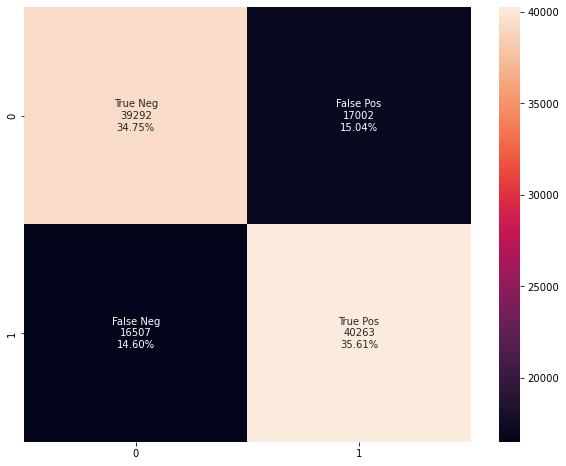

In [100]:
cf_matrix  = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cf_matrix, annot=labels, fmt='')

Доля ошибочно прогнозируемых значение достаточно большая

Попробуем обучить модель градиентного бустинга

In [101]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print(f'TRAIN {classification_report(y_train_true, y_train_pred)}')
    print(f'TEST {classification_report(y_test_true, y_test_pred)}')

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN               precision    recall  f1-score   support

           0       0.71      0.69      0.70    226366
           1       0.70      0.71      0.70    225890

    accuracy                           0.70    452256
   macro avg       0.70      0.70      0.70    452256
weighted avg       0.70      0.70      0.70    452256

TEST               precision    recall  f1-score   support

           0       0.70      0.70      0.70     56294
           1       0.70      0.71      0.71     56770

    accuracy                           0.70    113064
   macro avg       0.70      0.70      0.70    113064
weighted avg       0.70      0.70      0.70    113064



# CatBoost

Загрузим данные снова (для чистоты эксперимента) 

In [110]:
df_train = pd.read_csv('data/application_train.csv')
df_train = df_train.join(previous_application, how='left', on='SK_ID_CURR', rsuffix='_previous')
df_train = df_train.join(POS_CASH_balance, how='left', on='SK_ID_CURR', rsuffix='_POS_CASH')
df_train = df_train.join(credit_card_balance, how='left', on='SK_ID_CURR', rsuffix='_credit')
df_train = df_train.join(bureau, how='left', on='SK_ID_CURR', rsuffix='_bureau')
df_train.shape
df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          NaN           1               1                0   
4            -3458          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [111]:
target_train = df_train['TARGET']
df_train.drop(['SK_ID_CURR', 'TARGET'], axis=1, inplace=True)

Обработка категориальных переменных

In [112]:
cat_features = [f for f in df_train.columns if df_train[f].dtype == 'object']
def column_index(df_train, query_cols):
    cols = df_train.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter=sidx)]
cat_features_inds = column_index(df_train, cat_features)    
print("Cat features are: %s" % [f for f in cat_features])
print(cat_features_inds)

Cat features are: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'NAME_CONTRACT_TYPE_previous', 'WEEKDAY_APPR_PROCESS_START_previous', 'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE_previous', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'NAME_CONTRACT_STATUS_POS_CASH', 'NAME_CONTRACT_STATUS_credit', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY', 'CREDIT_TYPE']
[  0   1   2   3   9  10  11  12  13  26  30  38  84  85  87  88 122 128
 130 135 136 138 139 140 141 142 143 144 145 147 149 150 162 185 190 191
 

In [113]:
for col in cat_features:
    df_train[col] = le.fit_transform(df_train[col].astype(str))

In [114]:
df_train.fillna(-1, inplace=True)
cols = df_train.columns

Восстановление баланса между классами

In [116]:
smote = SMOTE(sampling_strategy = 'minority', random_state=99, k_neighbors=100)
df_train, target_train = smote.fit_resample(df_train, target_train)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(df_train, target_train, test_size=0.20, random_state=99)
print('Размер train: ', df_train.shape)
print('Размер target: ', target_train.shape)

Размер train:  (565372, 205)
Размер target:  (565372,)


In [118]:
cat_b = catb.CatBoostClassifier(iterations = 1000, # максимальное количество построенных деревьев
                                verbose = 20, # вывод итераций
                                early_stopping_rounds = 20, #  детектора переобучения
                                learning_rate  = 0.01, # скорость обучения
                                depth = 7, # глубина дерева
                                grow_policy  = 'Depthwise', # применение жадного алгоритма поиска
                                random_state = 99)

cat_b.fit(X_train, y_train,
          eval_set = (X_test, y_test),
          cat_features = cat_features_inds,
          use_best_model = True,
          verbose = True)
print(f'Качество модели на test: {cat_b.score(X_test, y_test)}\nКачество модели на train: {cat_b.score(X_train, y_train)}')

0:	learn: 0.6777294	test: 0.6777918	best: 0.6777918 (0)	total: 564ms	remaining: 9m 22s
1:	learn: 0.6655620	test: 0.6656208	best: 0.6656208 (1)	total: 980ms	remaining: 8m 9s
2:	learn: 0.6543087	test: 0.6543423	best: 0.6543423 (2)	total: 1.43s	remaining: 7m 53s
3:	learn: 0.6445418	test: 0.6445777	best: 0.6445777 (3)	total: 1.86s	remaining: 7m 43s
4:	learn: 0.6336840	test: 0.6337189	best: 0.6337189 (4)	total: 2.24s	remaining: 7m 26s
5:	learn: 0.6236425	test: 0.6236999	best: 0.6236999 (5)	total: 2.64s	remaining: 7m 18s
6:	learn: 0.6124341	test: 0.6125024	best: 0.6125024 (6)	total: 3.08s	remaining: 7m 17s
7:	learn: 0.6030413	test: 0.6030845	best: 0.6030845 (7)	total: 3.54s	remaining: 7m 18s
8:	learn: 0.5937996	test: 0.5938548	best: 0.5938548 (8)	total: 4.08s	remaining: 7m 29s
9:	learn: 0.5839415	test: 0.5839604	best: 0.5839604 (9)	total: 4.59s	remaining: 7m 34s
10:	learn: 0.5738371	test: 0.5738655	best: 0.5738655 (10)	total: 5.05s	remaining: 7m 33s
11:	learn: 0.5645088	test: 0.5645528	best:

In [119]:
predict_cat = cat_b.predict(X_test)
accuracy_cat = accuracy_score(y_test, predict_cat)
recall_cat = recall_score(y_test,predict_cat)
precision_cat = precision_score(y_test,predict_cat)
rocauc_cat = roc_auc_score(y_test,predict_cat)

print(f'Accuracy - {accuracy_cat:.4f}')
print(f'Recall - {recall_cat:.4f}')
print(f'Precision - {precision_cat:.4f}')
print(f'ROG AUC - {rocauc_cat:.4f}')
print(classification_report(y_test, predict_cat))

Accuracy - 0.9542
Recall - 0.9119
Precision - 0.9965
ROG AUC - 0.9544
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56367
           1       1.00      0.91      0.95     56708

    accuracy                           0.95    113075
   macro avg       0.96      0.95      0.95    113075
weighted avg       0.96      0.95      0.95    113075



CatBoost показал хороший результат

<AxesSubplot:>

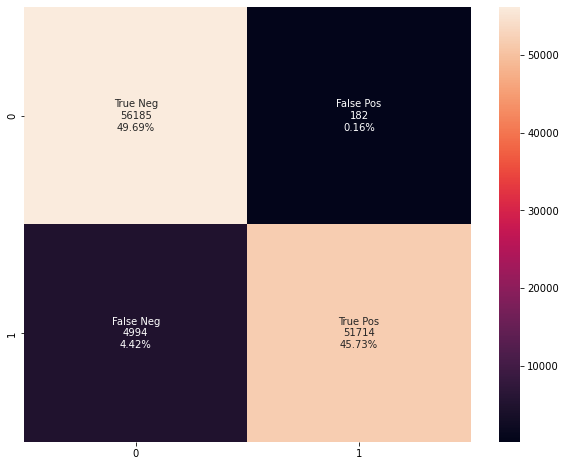

In [120]:
cf_matrix = confusion_matrix(y_test, predict_cat)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cf_matrix, annot=labels, fmt='')

In [121]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names' : feature_names, 'feature_importance' : feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending = False, inplace = True)
    
    plt.figure(figsize = (10, 8))
    sns.barplot(x = fi_df['feature_importance'], y = fi_df['feature_names'][:10])
    plt.xlabel('Важность признаков')
    plt.ylabel('Имена признаков')

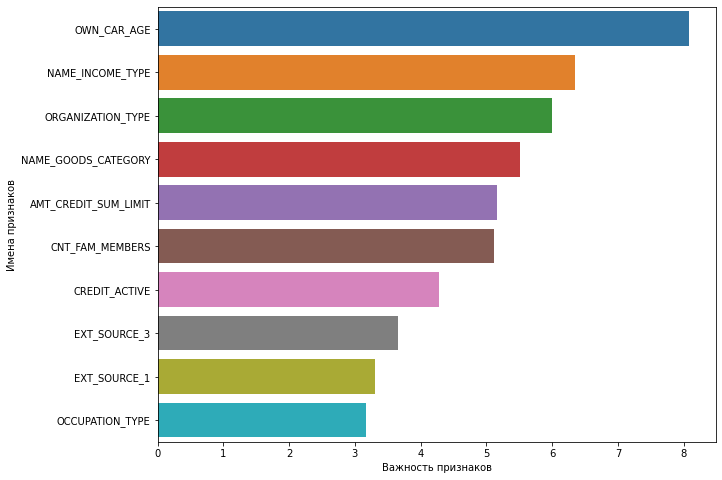

In [122]:
plot_feature_importance(cat_b.get_feature_importance(), df_train.columns,'CatBoost')

In [123]:
y_train_pred = cat_b.predict(X_train)
y_test_pred = cat_b.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN               precision    recall  f1-score   support

           0       0.92      1.00      0.96    226319
           1       1.00      0.91      0.95    225978

    accuracy                           0.96    452297
   macro avg       0.96      0.96      0.96    452297
weighted avg       0.96      0.96      0.96    452297

TEST               precision    recall  f1-score   support

           0       0.92      1.00      0.96     56367
           1       1.00      0.91      0.95     56708

    accuracy                           0.95    113075
   macro avg       0.96      0.95      0.95    113075
weighted avg       0.96      0.95      0.95    113075

